In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import chart_studio.plotly as py
import plotly.graph_objs as go 
import datetime as dt
import dataframe_image as dfi
import Levenshtein as lev
import re

In [2]:
df = pd.read_csv("GCST.csv", low_memory = False)

In [3]:
# PW_CODE CLEAN UP
df["PW_SOC_CODE"] = df["PW_SOC_CODE"].astype(str)
# PW_SOC_CODES that do not follow the standard XX-XXXX, missing "-"
wrongsoc = df[~df["PW_SOC_CODE"].str.contains("-", na = False)]
# DROPPING ANY APPLICANTS THAT DO NOT HAVE "-" IN PW SOC CODE
df = df[df["PW_SOC_CODE"].str.contains("-", na = False)]

In [4]:
# RESET DF INDEX
df = df.reset_index(drop = True)

In [5]:
# SPLITTING PW_SOC_CODE FOR CLEANING DECIMALS
# COL1 will be pre "-", COL2 will be after "-"... DROP THE DECIMALS (OLDER FORMAT, NOW MORE CONSOLIDATED)
symbol = df["PW_SOC_CODE"].str.find("-")
list1 = []
for x in range(len(df)):
    j = df["PW_SOC_CODE"][x][:symbol[x]]
    list1.append(j)
list2 = []
for x in range(len(df)):
    j = df["PW_SOC_CODE"][x][symbol[x]:]
    list2.append(j)

In [6]:
# COL1: HAS SOME WEIRD FORMATTING FROM CSV... TURNED IT INTO DATES... NOVEMBER IS IN THERE, SHOULD BE 11
col1 = pd.DataFrame(list1)
#col1[col1[0].str.len()>2][0].unique()
col1[0] = col1[0].replace("Nov",11)

In [7]:
# DROPPING ANYTHING AFTER DECIMAL FOR COL2
list2 = [sub.replace('-', '') for sub in list2]
col2 = pd.DataFrame(list2)
decimal = col2[col2[0].str.find(".")>0][0].str[:-3]
col2[0].loc[decimal.index] = decimal
col2[0] = col2[0].astype(str)

In [8]:
# HOW MANY Novs were there? THERE SHOULD BE MATCHING 2 DIGIT in Col2
(pd.DataFrame(list1)[0]=="Nov").sum() == len(col2[col2[0].str.len()<4])

False

In [9]:
# TURNING 2 DIGIT Col2 and adding 00 at the end
col2add = col2[col2[0].str.len()<4][0].astype(str)+"00"
col2[0].loc[col2add.index] = col2add
col2[0] = col2[0].astype(str)

In [10]:
# PUTTING BACK TOGETHER PW CODE CODE
df["PW_SOC_CODE"] = col1.astype(str)+"-"+col2.astype(str)

In [11]:
# RESET INDEX
df = df.reset_index(drop = True)

In [12]:
# CHANGING DECISION DATE AND APPLICATION RECEIVE DATE INTO MONTH OF YEAR 
df["MONTH"] = pd.to_datetime(df["DECISION_DATE"]).apply(lambda x:x.month)
df["YEAR"] = pd.to_datetime(df["DECISION_DATE"]).apply(lambda x:x.year)

In [13]:
# changing certified and certified expired to 1. and withdrawn and denied to 0: CLASSIFICATION MODEL OUTPUT
df["CASE_STATUS"] = df["CASE_STATUS"].replace(["CERTIFIED-EXPIRED","CERTIFIED"],[1,1]).replace(["WITHDRAWN","DENIED"],[0,0])

In [14]:
# HOW MANY WAGE OFFERED AND PW_WAGE ARE NULL? HOW MANY UNITS ARE NULL?
print("Number of PW Wage null:",len(df[df["PW_WAGE"].isnull()]))
print("Number of Wage offered null:",len(df[df["WAGE_OFFER_FROM"].isnull()]))
print("Number of PW Wage Unit Null:",len(df[df["PW_UNIT_OF_PAY"].isnull()]))
print("Number of Wage Unit null:",len(df[df["WAGE_OFFER_UNIT_OF_PAY"].isnull()]))

Number of PW Wage null: 24
Number of Wage offered null: 50
Number of PW Wage Unit Null: 1173
Number of Wage Unit null: 1179


In [15]:
# DF COPY TO SEE HOW MANY WERE DROPPED
dfc = df

In [16]:
# DROP ALL APPLICANTS WITH NO WAGE UNIT
df = df[df["WAGE_OFFER_UNIT_OF_PAY"].notnull()]
# DROP ALL APPLICANTS WITH NO PW UNIT
df = df[df["PW_UNIT_OF_PAY"].notnull()]
# DROP ALL APPLICANTS WITH NO WAGE OFFERED
df = df[df["WAGE_OFFER_FROM"].notnull()]
# DROP ALL APPLICANTS WITH NO PW WAGE
df = df[df["PW_WAGE"].notnull()]

In [17]:
# HOW MANY DROPPED DUE TO NULL
len(dfc)-len(df)

1236

In [18]:
# DF COPY TO SEE HOW MANY WERE DROPPED
dfc = df

In [19]:
# TURNING ALL WAGES TO FLOATS
df["WAGE_OFFER_FROM"] = df["WAGE_OFFER_FROM"].str.replace(",","")
df = df[df["WAGE_OFFER_FROM"]!="#############"]
df["PW_WAGE"] = df["PW_WAGE"].str.replace(",","")
df = df[df["PW_WAGE"]!="#############"]
df["WAGE_OFFER_FROM"] = df["WAGE_OFFER_FROM"].astype(float)
df["PW_WAGE"] = df["PW_WAGE"].astype(float)

In [20]:
# HOW MANY DROPPED DUE TO #######?
len(dfc)-len(df)

6

In [21]:
# STANDARD THE PW and SALARY UNIT OF PAY
df["PW_UNIT_OF_PAY"] = df["PW_UNIT_OF_PAY"].replace(["HOUR","YEAR","WEEK","MONTH","BI-WEEKLY"],["HR","YR","WK","MTH","BI"])
df["WAGE_OFFER_UNIT_OF_PAY"] = df["WAGE_OFFER_UNIT_OF_PAY"].replace(["HOUR","YEAR","WEEK","MONTH","BI-WEEKLY"],["HR","YR","WK","MTH","BI"])

In [22]:
# DISTRIBUTION OF UNIT OF PAY
pd.DataFrame([df["WAGE_OFFER_UNIT_OF_PAY"].value_counts(),df["PW_UNIT_OF_PAY"].value_counts(),df["WAGE_OFFER_UNIT_OF_PAY"].value_counts()-df["PW_UNIT_OF_PAY"].value_counts()]).transpose()

,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,Unnamed 0
YR,709971,723498,-13527
HR,24886,11644,13242
WK,280,133,147
MTH,218,107,111
BI,58,31,27


In [23]:
# ANNUALIZING WAGE OFFER AND PW
# Annualized Salaries: Actual Salary: multiplier
def annual(row):
    if row["WAGE_OFFER_UNIT_OF_PAY"] == "YR":
        return 1
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "MTH": 
        return 12
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "WK": 
        return 52
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "BI": 
        return 26
    elif row["WAGE_OFFER_UNIT_OF_PAY"] == "HR": 
        return 2080
mult = pd.DataFrame(df.apply(lambda row:annual(row), axis = 1))
mult.columns = ["WAGE_OFFER_FROM"]
# ANNUALIZED WAGE OFFER
df["WO_A"] = pd.DataFrame(df["WAGE_OFFER_FROM"])*mult

# Annualized Salaries: PW Salary
def annuali(row):
    if row["PW_UNIT_OF_PAY"] == "YR":
        return 1
    elif row["PW_UNIT_OF_PAY"] == "MTH": 
        return 12
    elif row["PW_UNIT_OF_PAY"] == "WK": 
        return 52
    elif row["PW_UNIT_OF_PAY"] == "BI": 
        return 26
    elif row["PW_UNIT_OF_PAY"] == "HR": 
        return 2080
multi = pd.DataFrame(df.apply(lambda row:annuali(row), axis = 1))
multi.columns = ["PW_WAGE"]
# ANNUALIZED WAGE PW
df["PW_A"] = pd.DataFrame(df["PW_WAGE"])*multi

In [24]:
# ANNUALIZED WAGE OFFER - ANNUALIZED PW
df["WO-PW"] = df["WO_A"] - df["PW_A"]

In [25]:
# STANDARDIZING THE NULLS
df = df.replace(np.nan,"", regex = True)

In [26]:
# HAVE WAGE OFFER BEEN < ANNUALIZED PW? THIS SOULD NEVER HAPPEN...
lowwage = df[df["WO-PW"]<0][["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]
lowwage

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
736,1,HR,YR,16.16,33613.00,33612.8,33613.0
1008,1,HR,YR,20.27,42162.00,42161.6,42162.0
1009,1,HR,YR,20.27,42162.00,42161.6,42162.0
1281,1,HR,YR,20.27,42162.00,42161.6,42162.0
4453,1,HR,YR,11.41,23733.00,23732.8,23733.0
...,...,...,...,...,...,...,...
732094,0,HR,HR,13.00,40.75,27040.0,84760.0
732246,0,HR,HR,11.50,12.00,23920.0,24960.0
732287,0,HR,HR,25.00,26.07,52000.0,54225.6
732288,0,HR,HR,25.00,26.07,52000.0,54225.6


In [27]:
# HOW MANY HAVE SUCCESSFUL APPLICATIONS WHEN WAGE < PW?
print("Number of Successful applicants:",lowwage["CASE_STATUS"].sum())
print("Out of:",len(lowwage),",",lowwage["CASE_STATUS"].sum()/len(lowwage))

Number of Successful applicants: 829
Out of: 1460 , 0.5678082191780822


In [28]:
# SUCESSFULL APPLICATIONS WITH THE SAME UNIT
lowwage[lowwage["WAGE_OFFER_UNIT_OF_PAY"]==lowwage["PW_UNIT_OF_PAY"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
7334,0,YR,YR,40000.0,94078.00,40000.0,94078.0
8190,0,YR,YR,21019.0,27019.00,21019.0,27019.0
12462,0,YR,YR,27394.0,27934.00,27394.0,27934.0
15349,0,YR,YR,106038.0,128898.00,106038.0,128898.0
16112,0,YR,YR,106038.0,110677.00,106038.0,110677.0
...,...,...,...,...,...,...,...
732094,0,HR,HR,13.0,40.75,27040.0,84760.0
732246,0,HR,HR,11.5,12.00,23920.0,24960.0
732287,0,HR,HR,25.0,26.07,52000.0,54225.6
732288,0,HR,HR,25.0,26.07,52000.0,54225.6


In [29]:
# CREATE A UNIQUE IDENTIFIER: THIS WILL BE TO UPDATE ANY OUTLIERS
df["ID"] = df["CASE_NUMBER"].astype(str)+df["DECISION_DATE"].astype(str)+df["CASE_STATUS"].astype(str)+df["RECEIVED_DATE"].astype(str)+df["DAYS_TO_DECIDE"].astype(str)+df["EMPLOYER_NAME"].astype(str)

In [30]:
# PATTERN FOR MIS-LABELED: UNIT OF PAY IS NOT YEAR BUT THE WAGE OFFER IS YEAR AMOUNT
# FIND THIS BY UNIT OF PAY NOT YEAR, BUT WAGE OFFER > btm 5% OF WAGE OFFER of each YEAR
top = df[df["WAGE_OFFER_UNIT_OF_PAY"]=="YR"].groupby("YEAR")["WAGE_OFFER_FROM"].quantile(.05) 
top

YEAR
2014    44990.88
2015    32000.00
2016    25240.00
2017    25064.00
2018    28018.00
2019    27000.00
2020    27830.00
2021    29328.00
Name: WAGE_OFFER_FROM, dtype: float64

In [31]:
# CREATING THE LIST FOR THE FOR LOOP TO REPLACE IF ANNUALIZED SALARY IS > OUTLIER CUTOFF
year = top.index.tolist()
top = top.tolist()

In [32]:
# GRABBING THE APPLICANTS THAT ARE OVER NON YR BUT > btm 5% of WAGE
todrop = pd.DataFrame()
for i in range(len(year)):
    j = df[(df["YEAR"]==year[i])&(df["WAGE_OFFER_FROM"]>=top[i])&(df["WAGE_OFFER_UNIT_OF_PAY"]!="YR")]
    todrop = pd.concat([todrop,j])
todrop[["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
524104,1,WK,YR,69493.0,69493.0,3613636.0,69493.0
524987,1,MTH,YR,115149.0,115149.0,1381788.0,115149.0
528015,0,MTH,MTH,45000.0,45000.0,540000.0,540000.0
531560,0,MTH,YR,80000.0,54280.0,960000.0,54280.0
535846,1,WK,YR,110000.0,105560.0,5720000.0,105560.0
...,...,...,...,...,...,...,...
58349,1,WK,YR,125000.0,66331.0,6500000.0,66331.0
77296,0,HR,YR,43867.0,43867.0,91243360.0,43867.0
87476,1,WK,YR,100000.0,73860.0,5200000.0,73860.0
88326,0,WK,YR,31096.0,31096.0,1616992.0,31096.0


In [33]:
# CHANGING THE WO_A TO THE WAGE OFFER (LEAVE UNIT OF PAY AS WHAT THE APPLICATION SAYS, ONLY CHANGE MY* Annualized WAGES)
todrop["WO_A"]=todrop["WAGE_OFFER_FROM"]

In [34]:
# CHECK IF UNIQUE IDENTIFIER IS UNIQUE
if len(df) == df["ID"].nunique():
    print("ID IS A UNIQUE IDENTIFIER")
else:
    print("ID IS NOT A UNIQUE IDENTIFIER")

ID IS NOT A UNIQUE IDENTIFIER


In [35]:
# WHAT IS THE MAX REPEAT OF IDs
df["ID"].value_counts()[df["ID"].value_counts()>1].max()

2

In [36]:
# ISOLATE THE APPLICATIONS WITH THE SAME ID
idcheck = df["ID"].value_counts()[df["ID"].value_counts()>1].index.tolist()

In [37]:
# CHECK TO SEE IF EACH DUPLICATE ID HAS IDENTICAL FIELDS (WOULD MEAN A MISTAKE AND THEN WE DROP). IF 0 THEN ALL IDENTICAL
empty = []
for i in range(len(idcheck)):
    df[df["ID"] == idcheck[i]]
    j = df[df["ID"] == idcheck[1]]
    if (j.iloc[0] == j.iloc[1]).sum() == len(j.columns):
        y = 0
        empty.append(y)
    else:
        y=[1]
sum(empty)

0

In [38]:
# DROP THE REPEAT APPLICATION FROM THE DF
df = df.drop_duplicates(subset=["ID"])

In [39]:
# CHANGING THE EXISTING APPLICANTS WITH UPDATED WAGE and UNIT OF PAY IN THE ORIGINAL DF
# MATCH APPLICATIONS IN TODROP DF WITH ORIGINAL DF AND UPDATE WAGE DATA
todrop = todrop.set_index("ID")
df = df.set_index("ID")
df.loc[todrop.index] = todrop
df = df.reset_index()

In [40]:
# PATTERN FOR MIS-LABELED: UNIT OF PAY IS NOT YEAR BUT THE PW WAGE IS YEAR AMOUNT
# FIND THIS BY UNIT OF PAY NOT YEAR, BUT PW WAGE > btm 5% OF PW WAGE of each YEAR
top1 = df[df["PW_UNIT_OF_PAY"]=="YR"].groupby("YEAR")["PW_WAGE"].quantile(.05) 
top1

YEAR
2014    39749.0
2015    29557.0
2016    20654.0
2017    21112.0
2018    22422.0
2019    23013.4
2020    23358.0
2021    24502.0
Name: PW_WAGE, dtype: float64

In [41]:
# CREATING THE LIST FOR THE FOR LOOP TO REPLACE IF ANNUALIZED SALARY IS > OUTLIER CUTOFF
year1 = top1.index.tolist()
top1 = top1.tolist()

In [42]:
# GRABBING THE APPLICANTS THAT ARE OVER NON YR BUT > btm 5% of PW_WAGE
todrop1 = pd.DataFrame()
for i in range(len(year)):
    j = df[(df["YEAR"]==year1[i])&(df["PW_WAGE"]>=top1[i])&(df["PW_UNIT_OF_PAY"]!="YR")]
    todrop1 = pd.concat([todrop1,j])
todrop1[["CASE_STATUS","WAGE_OFFER_UNIT_OF_PAY","PW_UNIT_OF_PAY","WAGE_OFFER_FROM","PW_WAGE","WO_A","PW_A"]]

,CASE_STATUS,WAGE_OFFER_UNIT_OF_PAY,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,PW_WAGE,WO_A,PW_A
527928,0,MTH,MTH,45000.00,45000.00,45000.00,5.400000e+05
699636,1,HR,HR,50544.00,50544.00,50544.00,1.051315e+08
448022,1,YR,HR,110000.00,106267.00,110000.00,2.210354e+08
614415,0,YR,HR,77147.00,77147.00,77147.00,1.604658e+08
630213,0,YR,HR,110000.00,106267.00,110000.00,2.210354e+08
456013,0,YR,HR,111760.00,95846.00,111760.00,1.993597e+08
464596,1,YR,HR,104000.00,66789.00,104000.00,1.389211e+08
212736,0,YR,HR,77958.00,77958.00,77958.00,1.621526e+08
330653,1,WK,WK,107536.00,107536.00,107536.00,5.591872e+06
330872,0,BI,BI,203000.00,202390.00,203000.00,5.262140e+06


In [43]:
# CHANGING THE PW_A TO THE WAGE OFFER AGAIN LEAVING THE UNIT LIKE WO_A
todrop1["PW_A"]=todrop1["PW_WAGE"]

In [44]:
# CHANGING THE EXISTING APPLICANTS WITH UPDATED WAGE and UNIT OF PAY IN THE ORIGINAL DF
# MATCH APPLICATIONS IN TODROP DF WITH ORIGINAL DF AND UPDATE WAGE DATA
todrop1 = todrop1.set_index("ID")
df = df.set_index("ID")
df.loc[todrop1.index] = todrop1
df = df.reset_index()

In [45]:
# CONTINUE CLEANING OUTLIERS IF PW_UNIT IS NOT THE SAME AS WAGE_UNIT BUT WAGE_OFFER AND PW_WAGE IS THE SAME & PW UNIT IS YR:
# UPDATE WO_A TO PW_A
clean = df[(df["WAGE_OFFER_FROM"]==df["PW_WAGE"])&(df["PW_UNIT_OF_PAY"]!=df["WAGE_OFFER_UNIT_OF_PAY"])&(df["PW_UNIT_OF_PAY"]=="YR")]
clean["WO_A"]=clean["PW_A"]
clean = clean.set_index("ID")
df = df.set_index("ID")
df.loc[clean.index] = clean
df = df.reset_index()

In [46]:
# DROPPING THE BTM 1% FROM EACH YEAR
# SETTING UP THE FOR LOOP
wagebtm = df.groupby("YEAR")["WO_A"].quantile(.01)
pwbtm = df.groupby("YEAR")["PW_A"].quantile(.01)
yr = wagebtm.index.tolist()
wagebtm = wagebtm.tolist()
pwbtm = pwbtm.tolist()

In [47]:
# FOR LOOP TO GET ALL APPLICANTS WITH WO_A < CUTOFF
emp = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["WO_A"]<wagebtm[x])]
    emp = pd.concat([emp,j])

In [48]:
# HOW MANY ARE DROPPED FOR WO_A<CUTOFF?
len(emp)

6959

In [49]:
# DROPPING ALL APPLICANTS WO_A < CUTOFF
emp = emp["ID"].tolist()
df = df[~df['ID'].isin(emp)]

In [50]:
# FOR LOOP TO GET ALL APPLICANTS WITH PW_A < CUTOFF
empt = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["PW_A"]<pwbtm[x])]
    empt = pd.concat([empt,j])

In [51]:
# HOW MANY ARE DROPPED FOR PW_A < CUTOFF?
len(empt)

1643

In [52]:
# DROPPING ALL APPLICANTS PW < CUTOFF
empt = empt["ID"].tolist()
df = df[~df['ID'].isin(empt)]

<AxesSubplot:ylabel='Frequency'>

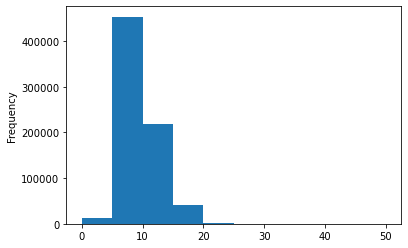

In [53]:
# CLEANING CITIES: EVENTUALLY WILL BE USED TO CREATE AVG WAGE TO REPLACE EXTREME OUTLIER WAGES
# CLEAN UP JOB CITY: distribution of the length of the cities
df["WORKSITE_CITY"].str.len().plot(kind = "hist")

In [54]:
# TOO MANY TO MANUALLY CLEAN: BUT WE WILL TARGET CITIES UNDER 5 CHARECTERS TO SPELL OUT ANY ABR.
df[df["WORKSITE_CITY"].str.len()<5]["WORKSITE_CITY"].unique()

array(['BREA', 'TROY', 'CARY', 'KATY', 'LEHI', 'WEED', 'NOVI', 'LAIE',
       'KENT', 'RENO', 'LULA', 'ERIE', 'YORK', 'STOW', 'OREM', 'NYC',
       'ANZA', 'YIGO', 'ELM', 'APEX', 'WACO', 'ROME', 'MESA', 'HAYS',
       'YUMA', 'KYLE', 'NY', 'ELKO', 'AVON', 'ENID', 'BUDA', 'ELON',
       'YELM', 'NASH', 'NAPA', 'COPE', 'AMES', 'ELBA', 'LUTZ', 'COVE',
       'HILO', 'LYNN', 'FIFE', 'LIMA', 'GARY', 'AGAT', 'LODI', 'PERU',
       'GUAM', 'OMAK', 'HULL', 'ADA', 'ALMA', 'CUBA', 'KRUM', 'RAKE',
       'BEND', 'BELL', 'TAFT', 'POCA', 'RYE', 'TATE', 'RIVA', 'OAKS',
       'VONA', 'LEE', 'KULM', 'BEAR', 'IRMO', 'AZLE', 'OJAI', 'ELMA',
       'HOWE', 'MARS', 'VAIL', 'HOPE', 'ALVA', 'ROY', 'SWEA', 'SACO',
       'ZUNI', 'MOAB', 'POTH', 'KIEL', 'GILL', 'PALA', 'AJO', 'AYER',
       'COOK', 'ROTA', 'WADE', 'TAOS', 'EDEN', 'MACK', 'RAY', 'DYER',
       'ORD', 'AXIS', 'LUSK', 'VEGA', 'CA', 'ELY', 'RTP', 'DUNN', '',
       'DOON', 'BATH', 'NUNN', 'ALTO', 'PACE', 'WALL', 'SPUR', 'WARE',
       'CARO', 'L

In [55]:
# WHAT ARE THE TOP CITIES?
df["WORKSITE_CITY"].value_counts()[:15]

NEW YORK           43046
SEATTLE            22738
SAN FRANCISCO      20135
COLLEGE STATION    18520
REDMOND            16886
MOUNTAIN VIEW      16716
SAN JOSE           16423
SANTA CLARA        12175
CHICAGO            11773
HOUSTON            11616
SUNNYVALE          10925
PLANO               9231
AUSTIN              8013
LOS ANGELES         7802
EDISON              7205
Name: WORKSITE_CITY, dtype: int64

In [56]:
# HOW MANY VARIATIONS OF THE TOP CITIES?
#df[df["WORKSITE_CITY"].str.contains("edison", case = False, na = False)]["WORKSITE_CITY"].value_counts()

In [57]:
# TURNING ALL THE NYC VARATIONS INTO NEW YORK + SPELL OUT NEW YORK
df["WORKSITE_CITY"] =  df["WORKSITE_CITY"].replace("NY","NEW YORK").replace("NYC","NEW YORK")
df.loc[df["WORKSITE_CITY"].str.contains("new york", case = False, na = False), "WORKSITE_CITY"] = "NEW YORK"
# MERGING THE TOP 15 cities (COLLEGE STATION, PLANO DOES NOT NEED CLEANING)
df.loc[df["WORKSITE_CITY"].str.contains("seattle", case = False, na = False), "WORKSITE_CITY"] = "SEATTLE"
df.loc[df["WORKSITE_CITY"].str.contains("san francisco", case = False, na = False), "WORKSITE_CITY"] = "SAN FRANCISCO"
df.loc[df["WORKSITE_CITY"].str.contains("REDMOND", case = False, na = False), "WORKSITE_CITY"] = "REDMOND"
df.loc[df["WORKSITE_CITY"].str.contains("mountain view", case = False, na = False), "WORKSITE_CITY"] = "MOUNTAIN VIEW"
df.loc[df["WORKSITE_CITY"].str.contains("san jose", case = False, na = False), "WORKSITE_CITY"] = "SAN JOSE"
df.loc[df["WORKSITE_CITY"].str.contains("santa clara", case = False, na = False), "WORKSITE_CITY"] = "SANTA CLARA"
df.loc[df["WORKSITE_CITY"].str.contains("chicago", case = False, na = False), "WORKSITE_CITY"] = "CHICAGO"
df.loc[df["WORKSITE_CITY"].str.contains("houston", case = False, na = False), "WORKSITE_CITY"] = "HOUSTON"
df.loc[df["WORKSITE_CITY"].str.contains("sunnyvale", case = False, na = False), "WORKSITE_CITY"] = "SUNNYVALE"
df.loc[df["WORKSITE_CITY"].str.contains("austin/|austin,", case = False, na = False), "WORKSITE_CITY"] = "AUSTIN"
df.loc[df["WORKSITE_CITY"].str.contains("los angeles", case = False, na = False), "WORKSITE_CITY"] = "LOS ANGELES"
df.loc[df["WORKSITE_CITY"].str.contains("edison", case = False, na = False), "WORKSITE_CITY"] = "EDISON"

In [58]:
# HOW MANY STATES ARE APPLICANTS TRYING TO WORK IN? SHOULD BE NO MORE THAN 60...
df["WORKSITE_STATE"].nunique()

114

In [59]:
# CREATING THE MAIN LIST TO TRY AND CLEAN MOST STATES INTO ABBREVIATIONS
mainst= ["Alabama",
"Alaska",
"Arizona",
"Arkansas",
"California",
"Colorado",
"Connecticut",
"Delaware",
"Florida",
"Georgia",
"Hawaii",
"Idaho",
"Illinois",
"Indiana",
"Iowa",
"Kansas",
"Kentucky",
"Louisiana",
"Maine",
"Maryland",
"Massachusetts",
"Michigan",
"Minnesota",
"Mississippi",
"Missouri",
"Montana",
"Nebraska",
"Nevada",
"New Hampshire",
"New Jersey",
"New Mexico",
"New York",
"North Carolina",
"North Dakota",
"Ohio",
"Oklahoma",
"Oregon",
"Pennsylvania",
"Rhode Island",
"South Carolina",
"South Dakota",
"Tennessee",
"Texas",
"Utah",
"Vermont",
"Virginia",
"Washington",
"West Virginia",
"Wisconsin",
"Wyoming",
"District of Columbia"]

In [60]:
# CREATING THE MAIN ABR TO TRY AND CLEAN MOST STATES INTO ABBREVIATIONS
mainabr = ["AL",
"AK",
"AZ",
"AR",
"CA",
"CO",
"CT",
"DE",
"FL",
"GA",
"HI",
"ID",
"IL",
"IN",
"IA",
"KS",
"KY",
"LA",
"ME",
"MD",
"MA",
"MI",
"MN",
"MS",
"MO",
"MT",
"NE",
"NV",
"NH",
"NJ",
"NM",
"NY",
"NC",
"ND",
"OH",
"OK",
"OR",
"PA",
"RI",
"SC",
"SD",
"TN",
"TX",
"UT",
"VT",
"VA",
"WA",
"WV",
"WI",
"WY",
"DC"]

In [61]:
# ROUND 1 CLEANING STATES
for j in range(len(mainst)):
    df.loc[df["WORKSITE_STATE"].str.contains(mainst[j], case = False, na = False), "WORKSITE_STATE"] = mainabr[j]

In [62]:
# HOW MANY STATES ARE THERE NOT ABR AFTER ROUND 1 CLEANING?
df["WORKSITE_STATE"].unique()[np.vectorize(len)(df["WORKSITE_STATE"].unique())>2]

array(['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA'], dtype=object)

In [63]:
# CREATING THE SECONDARY LIST TO FINISH CLEANING STATES
secondst = ['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA']
secondabr = ["PR","GU","MP","VI","MH","FSM"]
# ROUND 2 CLEANING STATES
for j in range(len(secondst)):
    df.loc[df["WORKSITE_STATE"].str.contains(secondst[j], case = False, na = False), "WORKSITE_STATE"] = secondabr[j]

In [64]:
# CREATING US GEOGRAPHIC REGION: STATE LIST
geostate = ["AK",
"AL",
"AR",
"AZ",
"CA",
"CO",
"CT",
"DC",
"DE",
"FL",
"GA",
"HI",
"IA",
"ID",
"IL",
"IN",
"KS",
"KY",
"LA",
"MA",
"MD",
"ME",
"MI",
"MN",
"MO",
"MS",
"MT",
"NC",
"ND",
"NE",
"NH",
"NJ",
"NM",
"NV",
"NY",
"OH",
"OK",
"OR",
"PA",
"RI",
"SC",
"SD",
"TN",
"TX",
"UT",
"VA",
"VT",
"WA",
"WI",
"WV",
"WY",
"PR",
"GU",
"MP",
"VI",
"MH",
"FSM"]

In [65]:
# CREATING US GEOGRAPHIC REGION: REGION LIST
region= ["WEST",
"SOUTH",
"SOUTH",
"WEST",
"WEST",
"WEST",
"NORTHEAST",
"SOUTH",
"SOUTH",
"SOUTH",
"SOUTH",
"WEST",
"MIDWEST",
"WEST",
"MIDWEST",
"MIDWEST",
"MIDWEST",
"SOUTH",
"SOUTH",
"NORTHEAST",
"SOUTH",
"NORTHEAST",
"MIDWEST",
"MIDWEST",
"MIDWEST",
"SOUTH",
"WEST",
"SOUTH",
"MIDWEST",
"MIDWEST",
"NORTHEAST",
"NORTHEAST",
"WEST",
"WEST",
"NORTHEAST",
"MIDWEST",
"SOUTH",
"WEST",
"NORTHEAST",
"NORTHEAST",
"SOUTH",
"MIDWEST",
"SOUTH",
"SOUTH",
"WEST",
"SOUTH",
"NORTHEAST",
"WEST",
"MIDWEST",
"SOUTH",
"WEST",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY",
"TERRITORY"]

In [66]:
# CREATING A WORKSITE REGION COLUMN
df["WORKSITE_REGION"]=df["WORKSITE_STATE"]
for j in range(len(geostate)):
    df.loc[df["WORKSITE_REGION"].str.contains(geostate[j], case = False, na = False), "WORKSITE_REGION"] = region[j]

In [67]:
# UNIQUE REGIONS (CHECK IF ALL STATES WERE TRANSLATED CORRECTLY)
df["WORKSITE_REGION"].unique()

array(['WEST', 'MIDWEST', 'SOUTH', 'NORTHEAST', 'TERRITORY', ''],
      dtype=object)

In [68]:
# OUTLIER WO_A USING IQR (EXTREME OUTLIER PER YEAR) TOP SIDE
wagetop = df.groupby("YEAR")["WO_A"].quantile(.75) + (df.groupby("YEAR")["WO_A"].quantile(.75)-df.groupby("YEAR")["WO_A"].quantile(.25)) *3
pwtop = df.groupby("YEAR")["PW_A"].quantile(.75) + (df.groupby("YEAR")["PW_A"].quantile(.75)-df.groupby("YEAR")["PW_A"].quantile(.25)) *3

In [69]:
# CREATING LISTS TO CLEAN UP WAGE BASED ON OUTLIERS : TOP END ONLY... DROP BOTTOM 1% (LAWS PROTECTING THE BTM END... MORE LIKELY TOP END IS ERROR)
yr = wagetop.index.tolist()
wagetop = wagetop.tolist()
pwtop = pwtop.tolist()

In [70]:
# FOR LOOP TO GET ALL APPLICANTS WITH WO_A > CUTOFF: BIGWAGE
bigwage = pd.DataFrame()
for x in range(len(yr)):
    j = df[(df["YEAR"] == yr[x])&(df["WO_A"]>wagetop[x])]
    bigwage = pd.concat([bigwage,j])

In [71]:
# GETTING THE REST OF THE APPLICANTS WHO ARE NOT > CUTOFF: REGWAGE
bwlist = bigwage["ID"].tolist()
regwage = df[~df['ID'].isin(bwlist)]

In [72]:
# CREATING A UNIQUE IDENTIFIER TO GET AN AVG WAGE FOR EACH IDENTIFIER TO REPLACE OUTLIER SALARIES
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_STATE"].astype(str) + regwage["WORKSITE_CITY"].astype(str) + regwage["PW_SKILL_LEVEL"].astype(str)
# IS THIS TOO GRANULAR OF AN AVG? LETS SEE AVG COUNT FOR EACH UNIQUE IDENTIFIER
regwage.groupby("BID")["WO_A"].value_counts().mean()

2.10322039232141

In [73]:
# NEW IDENTIFIER : USING STATE ONLY
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_STATE"].astype(str)+ regwage["PW_SKILL_LEVEL"].astype(str)
regwage.groupby("BID")["WO_A"].value_counts().mean()
# STILL ONLY 2.7  APPLICANTS A CODE

2.7774250522354462

In [74]:
# NEW IDENTIFIER : USING REGION ONLY
regwage["BID"] = regwage["PW_SOC_CODE"].astype(str)+regwage["WORKSITE_REGION"].astype(str)+ regwage["PW_SKILL_LEVEL"].astype(str)
regwage.groupby("BID")["WO_A"].value_counts().mean()
# BETTER with 3.3... 

3.326389912992184

In [75]:
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
normwage = pd.DataFrame(regwage.groupby("BID")["WO_A"].mean())
normpw = pd.DataFrame(regwage.groupby("BID")["PW_A"].mean())
normwage.columns=["NORM_WAGE"]
normpw.columns = ["NORM_PW"]

In [76]:
# CREATING THE UNIQUE IDENTIFIER FOR BIG WAGE TO MATCH UP WITH REG WAGE AVG
bigwage["BID"] = bigwage["PW_SOC_CODE"].astype(str)+bigwage["WORKSITE_REGION"].astype(str)+ bigwage["PW_SKILL_LEVEL"].astype(str)

In [77]:
# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchbidwage = bigwage
matchbidwage = matchbidwage.merge(normwage, how = "inner", on = "BID")

In [78]:
# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH BID
len(bigwage) - len(matchbidwage)

35

In [79]:
# LIST THE BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE BIDs NOT IN THE NORM WAGE...
bwregion = bigwage["BID"].unique().tolist()
normwageregion = normwage.index.tolist()
list(set(bwregion) - set(normwageregion))

['29-1069TERRITORYLEVEL I',
 '29-1064MIDWESTLEVEL IV',
 '29-1069TERRITORYLEVEL III',
 '29-1067SOUTHLEVEL III',
 '25-1051WESTLEVEL IV',
 '29-1067NORTHEAST',
 '29-1064NORTHEAST',
 '29-1061NORTHEAST',
 '11-1011SOUTH',
 '29-1067NORTHEASTLEVEL IV',
 '29-1063SOUTHLEVEL III',
 '29-1061NORTHEASTLEVEL I',
 '29-1061TERRITORYLEVEL III',
 '29-1022WESTLEVEL III',
 '29-1061SOUTHLEVEL III']

In [80]:
# GETTING THE APPLICANTS THAT DID NOT MATCH IN BID for NORM WAGE
nonmatchwage = pd.DataFrame()
for x in range(len(list(set(bwregion) - set(normwageregion)))):
    j = bigwage[bigwage["BID"]==list(set(bwregion) - set(normwageregion))[x]]
    nonmatchwage = pd.concat([nonmatchwage, j],axis = 0)

In [81]:
# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 35?
len(nonmatchwage)
# YES

35

In [82]:
# CORRELATION BETWEEN REGION OR LEVEL WITH WAGE: TO DETERMINE HOW TO ADJUST THE BID
regiondummy = pd.get_dummies(df["WORKSITE_REGION"])
leveldummy = pd.get_dummies(df["PW_SKILL_LEVEL"])

In [83]:
# CORREL BETWEEN REGIONS AND WO_A
pd.concat([regiondummy,df["WO_A"]],axis = 1).corr()["WO_A"]

            -0.002334
MIDWEST     -0.035596
NORTHEAST   -0.000939
SOUTH       -0.015371
TERRITORY   -0.021151
WEST         0.040113
WO_A         1.000000
Name: WO_A, dtype: float64

In [84]:
# CORREL BETWEEN LEVEL AND WO_A
pd.concat([leveldummy,df["WO_A"]],axis = 1).corr()["WO_A"]
# LEVELS LOOK MUCH HIGHER OVERALL 

             0.030534
LEVEL I     -0.140554
LEVEL II    -0.011339
LEVEL III    0.024664
LEVEL IV     0.105982
WO_A         1.000000
Name: WO_A, dtype: float64

In [85]:
# GETTING THE ADJUSTED BID FOR NORM WAGE: ONLY KEEPING LEVELS SINCE IT IS MORE CORREL WITH WAGE THAN REGION
adjregw = regwage
adjregw["BID"] = adjregw["PW_SOC_CODE"].astype(str)+adjregw["PW_SKILL_LEVEL"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
adjnormwage = pd.DataFrame(adjregw.groupby("BID")["WO_A"].mean())
adjnormwage.columns=["NORM_WAGE"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
adjbigwage = nonmatchwage
adjbigwage["BID"] = adjbigwage["PW_SOC_CODE"].astype(str)+ adjbigwage["PW_SKILL_LEVEL"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchadjbidwage = adjbigwage
matchadjbidwage = matchadjbidwage.merge(adjnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(adjbigwage) - len(matchadjbidwage)

2

In [86]:
# LIST THE Adj BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE Adj BIDs NOT IN THE NORM WAGE...
adjbwregion = adjbigwage["BID"].unique().tolist()
adjnormwageregion = adjnormwage.index.tolist()
list(set(adjbwregion) - set(adjnormwageregion))

['25-1051LEVEL IV', '29-1064LEVEL IV']

In [87]:
# LIST THE APPLICANTS THAT ARE STILL NOT MATCHED THROUGH BID...
nonmatchadjwage = pd.DataFrame()
for x in range(len(list(set(adjbwregion) - set(adjnormwageregion)))):
    j = adjbigwage[adjbigwage["BID"]==list(set(adjbwregion) - set(adjnormwageregion))[x]]
    nonmatchadjwage = pd.concat([nonmatchadjwage, j],axis = 0)

# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 2?
len(nonmatchadjwage)
# YES

2

In [88]:
# GETTING THE WAGE FOR SOC CODE ONLY FOR NORM WAGE
soconly = regwage
soconly["BID"] = soconly["PW_SOC_CODE"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
socnormwage = pd.DataFrame(soconly.groupby("BID")["WO_A"].mean())
socnormwage.columns=["NORM_WAGE"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
socbigwage = nonmatchadjwage
socbigwage["BID"] = socbigwage["PW_SOC_CODE"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchsocbidwage = socbigwage
matchsocbidwage = matchsocbidwage.merge(socnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(socbigwage) - len(matchsocbidwage)

0

In [89]:
# MERGING BACK TO MAKE THE FINAL BIG WAGE : USING NORM WAGE...
bigwage = pd.concat([matchbidwage,
matchadjbidwage,
matchsocbidwage],axis = 0, ignore_index = True)
bigwage["WO_A"] = bigwage["NORM_WAGE"]
bigwage = bigwage.drop("NORM_WAGE", axis = 1)

In [90]:
# CLEANING UP THE PW_A
# CREATING THE UNIQUE IDENTIFIER FOR BIG WAGE TO MATCH UP WITH REG WAGE AVG
bigwage["BID"] = bigwage["PW_SOC_CODE"].astype(str)+bigwage["WORKSITE_REGION"].astype(str)+ bigwage["PW_SKILL_LEVEL"].astype(str)

In [91]:
# MERGING BASED ON BID AND BRINGING IN NORM PW
matchbidwage = bigwage
matchbidwage = matchbidwage.merge(normpw, how = "inner", on = "BID")

In [92]:
# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH BID
len(bigwage) - len(matchbidwage)

35

In [93]:
# LIST THE BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE BIDs NOT IN THE NORM WAGE...
bwregion = bigwage["BID"].unique().tolist()
normwageregion = normpw.index.tolist()
list(set(bwregion) - set(normwageregion))

['29-1069TERRITORYLEVEL I',
 '29-1064MIDWESTLEVEL IV',
 '29-1069TERRITORYLEVEL III',
 '29-1067SOUTHLEVEL III',
 '25-1051WESTLEVEL IV',
 '29-1067NORTHEAST',
 '29-1064NORTHEAST',
 '29-1061NORTHEAST',
 '11-1011SOUTH',
 '29-1067NORTHEASTLEVEL IV',
 '29-1063SOUTHLEVEL III',
 '29-1061NORTHEASTLEVEL I',
 '29-1061TERRITORYLEVEL III',
 '29-1022WESTLEVEL III',
 '29-1061SOUTHLEVEL III']

In [94]:
# GETTING THE APPLICANTS THAT DID NOT MATCH IN BID for NORM PW
nonmatchwage = pd.DataFrame()
for x in range(len(list(set(bwregion) - set(normwageregion)))):
    j = bigwage[bigwage["BID"]==list(set(bwregion) - set(normwageregion))[x]]
    nonmatchwage = pd.concat([nonmatchwage, j],axis = 0)

In [95]:
# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 35?
len(nonmatchwage)
# YES

35

In [96]:
# GETTING THE ADJUSTED BID FOR NORM PW: ONLY KEEPING LEVELS SINCE IT IS MORE CORREL WITH WAGE THAN REGION
adjregw = regwage
adjregw["BID"] = adjregw["PW_SOC_CODE"].astype(str)+adjregw["PW_SKILL_LEVEL"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
adjnormwage = pd.DataFrame(adjregw.groupby("BID")["PW_A"].mean())
adjnormwage.columns=["NORM_PW"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
adjbigwage = nonmatchwage
adjbigwage["BID"] = adjbigwage["PW_SOC_CODE"].astype(str)+ adjbigwage["PW_SKILL_LEVEL"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchadjbidwage = adjbigwage
matchadjbidwage = matchadjbidwage.merge(adjnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(adjbigwage) - len(matchadjbidwage)

2

In [97]:
# LIST THE Adj BIDs THAT DO NOT MATCH IN NORM WAGE: THESE ARE THE Adj BIDs NOT IN THE NORM WAGE...
adjbwregion = adjbigwage["BID"].unique().tolist()
adjnormwageregion = adjnormwage.index.tolist()
list(set(adjbwregion) - set(adjnormwageregion))

['25-1051LEVEL IV', '29-1064LEVEL IV']

In [98]:
# LIST THE APPLICANTS THAT ARE STILL NOT MATCHED THROUGH BID...
nonmatchadjwage = pd.DataFrame()
for x in range(len(list(set(adjbwregion) - set(adjnormwageregion)))):
    j = adjbigwage[adjbigwage["BID"]==list(set(adjbwregion) - set(adjnormwageregion))[x]]
    nonmatchadjwage = pd.concat([nonmatchadjwage, j],axis = 0)

# DOES THE NUMBER OF APPLICANTS THAT DO NOT MATCH = TO 2?
len(nonmatchadjwage)
# YES

2

In [99]:
# GETTING THE WAGE FOR SOC CODE ONLY FOR NORM WAGE
soconly = regwage
soconly["BID"] = soconly["PW_SOC_CODE"].astype(str)
# NORMALIZED AVG WAGE FOR EACH UNIQUE IDENTIFIER
socnormwage = pd.DataFrame(soconly.groupby("BID")["PW_A"].mean())
socnormwage.columns=["NORM_PW"]

# CREATING THE UNIQUE IDENTIFIER FOR MISSING BIG WAGE TO MATCH UP WITH REG WAGE AVG
socbigwage = nonmatchadjwage
socbigwage["BID"] = socbigwage["PW_SOC_CODE"].astype(str)

# MERGING BASED ON BID AND BRINGING IN NORM WAGE
matchsocbidwage = socbigwage
matchsocbidwage = matchsocbidwage.merge(socnormwage, how = "inner", on = "BID")

# HOW MANY APPLICANTS WERE NOT MATCHED THROUGH AdjBID
len(socbigwage) - len(matchsocbidwage)

0

In [100]:
# MERGING BACK TO MAKE THE FINAL BIG WAGE : USING NORM WAGE...
bigwage = pd.concat([matchbidwage,
matchadjbidwage,
matchsocbidwage],axis = 0, ignore_index = True)
bigwage["PW_A"] = bigwage["NORM_PW"]
bigwage = bigwage.drop(["BID","NORM_PW"], axis = 1)

In [101]:
# MATCH APPLICATIONS IN BIGWAGE DF WITH ORIGINAL DF AND UPDATE WAGE AND PW DATA
bigwage = bigwage.set_index("ID")
df = df.set_index("ID")
df.loc[bigwage.index] = bigwage
df = df.reset_index()

In [102]:
# ANNUALIZED WAGE OFFER - ANNUALIZED PW: REDO, WITH CLEANED UP ANNUAL WAGE AND PW
df["WO-PW"] = df["WO_A"] - df["PW_A"]

<AxesSubplot:ylabel='Frequency'>

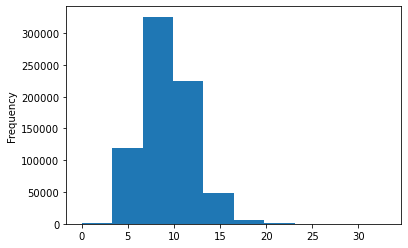

In [103]:
# CLEANING EMPLOYER HQ CITIES
# CLEAN UP JOB CITY: distribution of the length of the cities
df["EMPLOYER_CITY"].str.len().plot(kind = "hist")

In [104]:
# TOO MANY TO MANUALLY CLEAN: 
# WHAT ARE THE TOP CITIES?
df["EMPLOYER_CITY"].value_counts()[:15]

NEW YORK           41062
SEATTLE            24506
MOUNTAIN VIEW      21402
SANTA CLARA        21085
COLLEGE STATION    19646
SAN FRANCISCO      18349
SAN JOSE           18137
REDMOND            17907
CHICAGO            15309
SUNNYVALE          11828
HOUSTON            10303
PLANO               8655
CUPERTINO           7894
EDISON              7304
MENLO PARK          7258
Name: EMPLOYER_CITY, dtype: int64

In [105]:
# HOW MANY VARIATIONS OF THE TOP CITIES?
#df[df["EMPLOYER_CITY"].str.contains("mountain view", case = False, na = False)]["EMPLOYER_CITY"].value_counts()

In [106]:
# TURNING ALL THE NYC VARATIONS INTO NEW YORK + SPELL OUT NEW YORK
df["EMPLOYER_CITY"] =  df["EMPLOYER_CITY"].replace("NY","NEW YORK").replace("NYC","NEW YORK")
df.loc[df["EMPLOYER_CITY"].str.contains("new york", case = False, na = False), "EMPLOYER_CITY"] = "NEW YORK"
# MERGING THE TOP 15 cities (santa clara, COLLEGE STATION,redmond, cupertino, menlo park, and PLANO did NOT NEED CLEANING)
df.loc[df["EMPLOYER_CITY"].str.contains("seattle", case = False, na = False), "EMPLOYER_CITY"] = "SEATTLE"
df.loc[df["EMPLOYER_CITY"].str.contains("san francisco", case = False, na = False), "EMPLOYER_CITY"] = "SAN FRANCISCO"
df.loc[df["EMPLOYER_CITY"].str.contains("san jose", case = False, na = False), "EMPLOYER_CITY"] = "SAN JOSE"
df.loc[df["EMPLOYER_CITY"].str.contains("chicago", case = False, na = False), "EMPLOYER_CITY"] = "CHICAGO"
df.loc[df["EMPLOYER_CITY"].str.contains("houston", case = False, na = False), "EMPLOYER_CITY"] = "HOUSTON"
df.loc[df["EMPLOYER_CITY"].str.contains("sunnyvale", case = False, na = False), "EMPLOYER_CITY"] = "SUNNYVALE"
df.loc[df["EMPLOYER_CITY"].str.contains("los angeles", case = False, na = False), "EMPLOYER_CITY"] = "LOS ANGELES"
df.loc[df["EMPLOYER_CITY"].str.contains("edison", case = False, na = False), "EMPLOYER_CITY"] = "EDISON"

In [107]:
# HOW MANY STATES ARE EMPLOYERS HQ IN? SHOULD BE NO MORE THAN 60...
df["EMPLOYER_STATE_PROVINCE"].nunique()
# ... 1157

1157

In [108]:
# ROUND 1 CLEANING STATES
for j in range(len(mainst)):
    df.loc[df["EMPLOYER_STATE_PROVINCE"].str.contains(mainst[j], case = False, na = False), "EMPLOYER_STATE_PROVINCE"] = mainabr[j]

In [109]:
# HOW MANY STATES ARE THERE NOT ABR AFTER ROUND 1 CLEANING?
df["EMPLOYER_STATE_PROVINCE"].unique()[np.vectorize(len)(df["EMPLOYER_STATE_PROVINCE"].unique())>2]

array(['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'NORTHERN MARIANA ISLANDS CNMI', ' PR', 'GUAM ', 'GUAM GUAM',
       'NORTHERN MARIANA ISLANDS SAIPAN INTERNATIONAL SCHOOL',
       'VIRGIN ISLANDS ABC SALES & SERVICES', 'VIRGIN ISLANDS ST. CROIX',
       'PUERTO RICO SAN JUAN', ' FL 32773', ' FL BUILDIN',
       'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'PUERTO RICO PUERTO RICO', ' OR OR',
       'VIRGIN ISLANDS ST CROIX', 'PUERTO RICO PR',
       'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLAND',
       'FEDERATED STATES OF MICRONESIA', 'BRITISH COLUMBIA'], dtype=object)

In [110]:
df["EMPLOYER_STATE_PROVINCE"].unique()[np.vectorize(len)(df["EMPLOYER_STATE_PROVINCE"].unique())>2].tolist()

['PUERTO RICO',
 'GUAM',
 'NORTHERN MARIANA ISLANDS',
 'NORTHERN MARIANA ISLANDS CNMI',
 ' PR',
 'GUAM ',
 'GUAM GUAM',
 'NORTHERN MARIANA ISLANDS SAIPAN INTERNATIONAL SCHOOL',
 'VIRGIN ISLANDS ABC SALES & SERVICES',
 'VIRGIN ISLANDS ST. CROIX',
 'PUERTO RICO SAN JUAN',
 ' FL 32773',
 ' FL BUILDIN',
 'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLANDS',
 'VIRGIN ISLANDS',
 'PUERTO RICO PUERTO RICO',
 ' OR OR',
 'VIRGIN ISLANDS ST CROIX',
 'PUERTO RICO PR',
 'NORTHERN MARIANA ISLANDS NORTHERN MARIANA ISLAND',
 'FEDERATED STATES OF MICRONESIA',
 'BRITISH COLUMBIA']

In [111]:
# CREATING THE SECONDARY LIST TO FINISH CLEANING STATES
secondst = ['PUERTO RICO', 'GUAM', 'NORTHERN MARIANA ISLANDS',
       'VIRGIN ISLANDS', 'MARSHALL ISLANDS',
       'FEDERATED STATES OF MICRONESIA'," PR","FL 32773","FL BUILDIN","OR OR","BRITISH COLUMBIA"]
secondabr = ["PR","GU","MP","VI","MH","FSM","PR","FL","FL","OR","BC"]
# ROUND 2 CLEANING STATES
for j in range(len(secondst)):
    df.loc[df["EMPLOYER_STATE_PROVINCE"].str.contains(secondst[j], case = False, na = False), "EMPLOYER_STATE_PROVINCE"] = secondabr[j]

In [112]:
# CREATING A WORKSITE REGION COLUMN
df["EMPLOYER_REGION"]=df["EMPLOYER_STATE_PROVINCE"]
for j in range(len(geostate)):
    df.loc[df["EMPLOYER_REGION"].str.contains(geostate[j], case = False, na = False), "EMPLOYER_REGION"] = region[j]


In [113]:
# UNIQUE REGIONS (CHECK IF ALL STATES WERE TRANSLATED CORRECTLY)
df["EMPLOYER_REGION"] = df["EMPLOYER_REGION"].replace("BC","OTHER")
df["EMPLOYER_REGION"].unique()

array(['WEST', 'MIDWEST', 'SOUTH', 'NORTHEAST', 'TERRITORY', '', 'OTHER'],
      dtype=object)

In [114]:
# ADDING A CATEGORICAL VARIABLE OF DISCREPANCY BETWEEN EMPLOYER HQ STATE , REGION, AND CITY WITH JOB WORK SITE. UNIT OF WAGE AS WELL
df["DISC_ST"] = np.where(df["EMPLOYER_STATE_PROVINCE"]==df["WORKSITE_STATE"], 0, 1)
df["DISC_CTY"] = np.where(df["EMPLOYER_CITY"]==df["WORKSITE_CITY"], 0, 1)
df["DISC_RGION"] = np.where(df["EMPLOYER_REGION"]==df["WORKSITE_REGION"], 0, 1)
df["DISC_UNIT"] = np.where(df["WAGE_OFFER_UNIT_OF_PAY"]==df["PW_UNIT_OF_PAY"], 0, 1)

In [115]:
# MANUAL CLEANING OF EMPLOYER NAMES: THIS CODE IS TAKEN FROM THE US IMMIGRANT EMPLOYEMENT MINIPROJECT IN MY GITHUB
df.loc[df["EMPLOYER_NAME"].str.contains("GOOGLE", case = False, na = False),"EMPLOYER_NAME"]="GOOGLE"
df.loc[(df["EMPLOYER_NAME"].str.contains("amazon |amazon.com", case = False, na = False))&(~df["EMPLOYER_NAME"].str.contains("amazon conservation team|amazon stones", case = False, na = False)), "EMPLOYER_NAME"] = "AMAZON"
df.loc[df["EMPLOYER_NAME"].str.contains("MICROSOFT", case = False, na = False), "EMPLOYER_NAME"] = "MICROSOFT"
df.loc[df["EMPLOYER_NAME"].str.contains("Cognizant", case = False, na = False), "EMPLOYER_NAME"] = "COGNIZANT"
df.loc[df["EMPLOYER_NAME"].str.contains("intel corporation|intel mobile|intel massachusetts|intel america|intel federal", case = False, na = False), "EMPLOYER_NAME"] = "INTEL"
df.loc[df["EMPLOYER_NAME"].str.contains("apple inc.|apple computer|apple educational", case = False, na = False), "EMPLOYER_NAME"] = "APPLE"
df.loc[df["EMPLOYER_NAME"].str.contains("infosys ltd.|infosys technologies|infosys public|infosys solutions|infosys consulting|infosys international|infosys BPO", case = False, na = False), "EMPLOYER_NAME"] = "INFOSYS"
df.loc[df["EMPLOYER_NAME"].str.contains("facebook", case = False, na = False), "EMPLOYER_NAME"] = "FACEBOOK"
df.loc[df["EMPLOYER_NAME"].str.contains("tata consultancy|tata technologies|tata communications|tata industries|tata consltancy|tata enterprises|tata america international|tata autocomp|tata international metals|tata chemicals|tata elxsi", case = False, na = False), "EMPLOYER_NAME"] = "TATA"
df.loc[df["EMPLOYER_NAME"].str.contains("oracle america|oracle usa|oracle financial", case = False, na = False), "EMPLOYER_NAME"] = "FACEBOOK"
df.loc[df["EMPLOYER_NAME"].str.contains("hcl america", case = False, na = False), "EMPLOYER_NAME"] = "HCL AMERICA"
df.loc[df["EMPLOYER_NAME"].str.contains("deloitte", case = False, na = False), "EMPLOYER_NAME"] = "DELOITTE"
df.loc[df["EMPLOYER_NAME"].str.contains("qualcomm", case = False, na = False), "EMPLOYER_NAME"] = "QUALCOMM"
df.loc[df["EMPLOYER_NAME"].str.contains("IBM ", case = False, na = False), "EMPLOYER_NAME"] = "IBM"
df.loc[df["EMPLOYER_NAME"].str.contains("Cisco systems|cisco consumer", case = False, na = False), "EMPLOYER_NAME"] = "CISCO"
df.loc[df["EMPLOYER_NAME"].str.contains("salesforce", case = False, na = False), "EMPLOYER_NAME"] = "SALESFORCE"
df.loc[df["EMPLOYER_NAME"].str.contains("morgan stanley", case = False, na = False), "EMPLOYER_NAME"] = "MORGAN STANLEY"
df.loc[df["EMPLOYER_NAME"].str.contains("JP Morgan", case = False, na = False), "EMPLOYER_NAME"] = "JP MORGAN"
df.loc[df["EMPLOYER_NAME"].str.contains("goldman sachs|goldman, sachs|goldman,sachs", case = False, na = False), "EMPLOYER_NAME"] = "GOLDMAN SACHS"
df.loc[df["EMPLOYER_NAME"].str.contains("MERRILL LYNCH", case = False, na = False), "EMPLOYER_NAME"] = "MERRILL LYNCH"
df.loc[df["EMPLOYER_NAME"].str.contains("Citibank|citigroup", case = False, na = False), "EMPLOYER_NAME"] = "CITI GROUP"
df.loc[df["EMPLOYER_NAME"].str.contains("CREDIT SUISSE", case = False, na = False), "EMPLOYER_NAME"] = "CREDIT SUISSE"
df.loc[df["EMPLOYER_NAME"].str.contains("pricewater|pwc", case = False, na = False), "EMPLOYER_NAME"] = "PRICEWATERHOUSECOOPERS"
df.loc[df["EMPLOYER_NAME"].str.contains("ernst  |ernst & Young", case = False, na = False), "EMPLOYER_NAME"] = "ERNST YOUNG"
df.loc[df["EMPLOYER_NAME"].str.contains("capgemini", case = False, na = False), "EMPLOYER_NAME"] = "CAPGEMINI"
df.loc[df["EMPLOYER_NAME"].str.contains("technip usa", case = False, na = False), "EMPLOYER_NAME"] = "TECHNIP USA"
df.loc[df["EMPLOYER_NAME"].str.contains("bechtel ", case = False, na = False), "EMPLOYER_NAME"] = "BECHTEL"
df.loc[(df["EMPLOYER_NAME"].str.contains("hp enterprise services|hp inc.|Hewlett-|Hewlett P|HewlettP", case = False, na = False))&(~df["EMPLOYER_NAME"].str.contains("queen nails hp inc|backer ehp inc", case = False, na = False)), "EMPLOYER_NAME"] = "AMAZON"
df.loc[df["EMPLOYER_NAME"].str.contains("CGGVERITAS", case = False, na = False), "EMPLOYER_NAME"] = "CGGVERITAS"
df.loc[df["EMPLOYER_NAME"].str.contains("national oilwell", case = False, na = False), "EMPLOYER_NAME"] = "NATIONAL OILWELL VARCO"
df.loc[df["EMPLOYER_NAME"].str.contains("IH SERVICES", case = False, na = False), "EMPLOYER_NAME"] = "IH SERVICES"
df.loc[df["EMPLOYER_NAME"].str.contains("paypal", case = False, na = False), "EMPLOYER_NAME"] = "PAYPAL"
df.loc[df["EMPLOYER_NAME"].str.contains("EBAY INC.|EBAY INC|EBAY ENTERPRISE|EBAY MOBILE LABS| EBAY PAYMENTS", case = False, na = False), "EMPLOYER_NAME"] = "EBAY"
df.loc[df["EMPLOYER_NAME"].str.contains("brocade", case = False, na = False), "EMPLOYER_NAME"] = "BROCADE"
df.loc[df["EMPLOYER_NAME"].str.contains("ADOBE INC.|ADOBE SYSTEMS", case = False, na = False), "EMPLOYER_NAME"] = "ADOBE"
df.loc[df["EMPLOYER_NAME"].str.contains("University of Chicago", case = False, na = False), "EMPLOYER_NAME"] = "THE UNIVERSITY OF CHICAGO"
df.loc[df["EMPLOYER_NAME"].str.contains("mckinsey", case = False, na = False), "EMPLOYER_NAME"] = "MCKINSEY COMPANY"
df.loc[df["EMPLOYER_NAME"].str.contains("motorola", case = False, na = False), "EMPLOYER_NAME"] = "MOTOROLA"
df.loc[df["EMPLOYER_NAME"].str.contains("citadel LLC|citadel americas|citadel Securities|citadel investment|citadel enterprise", case = False, na = False), "EMPLOYER_NAME"] = "CITADEL LLC"
df.loc[df["EMPLOYER_NAME"].str.contains("yahoo", case = False, na = False), "EMPLOYER_NAME"] = "YAHOO"
df.loc[df["EMPLOYER_NAME"].str.contains("Juniper networks", case = False, na = False), "EMPLOYER_NAME"] = "JUNIPER NETWORKS"
df.loc[df["EMPLOYER_NAME"].str.contains("a2z development", case = False, na = False), "EMPLOYER_NAME"] = "A2Z DEVELOPMENT"
df.loc[df["EMPLOYER_NAME"].str.contains("walmart|wal-mart", case = False, na = False), "EMPLOYER_NAME"] = "WALMART"
df.loc[df["EMPLOYER_NAME"].str.contains("fortinet", case = False, na = False), "EMPLOYER_NAME"] = "FORTINET"
df.loc[df["EMPLOYER_NAME"].str.contains("larsen &|larsen  ", case = False, na = False), "EMPLOYER_NAME"] = "LARSEN TOUBRO"
df.loc[df["EMPLOYER_NAME"].str.contains("mindtree", case = False, na = False), "EMPLOYER_NAME"] = "MINDTREE LIMITED"
df.loc[df["EMPLOYER_NAME"].str.contains("igate tech|igate mastech|igate global", case = False, na = False), "EMPLOYER_NAME"] = "IGATE TECHNOLOGIES"
df.loc[df["EMPLOYER_NAME"].str.contains("3i info", case = False, na = False), "EMPLOYER_NAME"] = "3I INFOTECH"
df.loc[df["EMPLOYER_NAME"].str.contains("NTT Data", case = False, na = False), "EMPLOYER_NAME"] = "NTT DATA"
df.loc[df["EMPLOYER_NAME"].str.contains("Texas instrument", case = False, na = False), "EMPLOYER_NAME"] = "TEXAS INSTRUMENTS"
df.loc[df["EMPLOYER_NAME"].str.contains("tech mahindra", case = False, na = False), "EMPLOYER_NAME"] = "TECH MAHINDRA"
df.loc[df["EMPLOYER_NAME"].str.contains("DELL USA LP|DELL PRODUCTS LP|DELL MARKETING LP|DELL SOFTWARE INC|DELL FINANCIAL", case = False, na = False), "EMPLOYER_NAME"] = "DELL"
df.loc[df["EMPLOYER_NAME"].str.contains("uber technologies", case = False, na = False), "EMPLOYER_NAME"] = "UBER TECHNOLOGIES"
df.loc[df["EMPLOYER_NAME"].str.contains("case farms", case = False, na = False), "EMPLOYER_NAME"] = "CASE FARMS"
df.loc[df["EMPLOYER_NAME"].str.contains("house of raeford", case = False, na = False), "EMPLOYER_NAME"] = "HOUSE OF RAEFORD FARMS"
df.loc[df["EMPLOYER_NAME"].str.contains("george's processing", case = False, na = False), "EMPLOYER_NAME"] = "GEORGE'S PROCESSING"
df.loc[df["EMPLOYER_NAME"].str.contains("abbyland", case = False, na = False), "EMPLOYER_NAME"] = "ABBYLAND FOODS"
df.loc[df["EMPLOYER_NAME"].str.contains("koch foods of cinc", case = False, na = False), "EMPLOYER_NAME"] = "KOCH FOODS OF CINCINNATI"
df.loc[df["EMPLOYER_NAME"].str.contains("koch foods of al", case = False, na = False), "EMPLOYER_NAME"] = "KOCH FOODS OF ALABAMA"


In [116]:
# CREATING THE LIST OF COLUMNS THAT NEED CLEANING UP: "Y" OR "N" INTO 1 or 0
Y_N_cols = ["REFILE",
"REQUIRED_TRAINING",
"REQUIRED_EXPERIENCE",
"ACCEPT_FOREIGN_EDUCATION",
"ACCEPT_ALT_OCCUPATION",
"JOB_OPP_REQUIREMENTS_NORMAL",
"FOREIGN_LANGUAGE_REQUIRED",
"PROFESSIONAL_OCCUPATION",
"APP_FOR_COLLEGE_U_TEACHER",
"SUNDAY_EDITION_NEWSPAPER",
"SECOND_ADVERTISEMENT",
"JOB_FAIR",
"ON_CAMPUS_RECRUITING",
"EMPLOYER_WEBSITE",
"PRO_ORG_AD",
"JOB_SEARCH_WEBSITE",
"PVT_EMPLOYMENT_FIRM",
"EMPLOYEE_REF_PROG",
"CAMPUS_PLACEMENT",
"LOCAL_ETHNIC_PAPER",
"RADIO_TV_AD",
"EMP_RECEIVED_PAYMENT",
"BARGAINING_REP_NOTIFIED",
"POSTED_NOTICE_AT_WORKSITE",
"LAYOFF_IN_PAST_SIX_MONTHS",
"US_WORKERS_CONSIDERED",
"FOREIGN_WORKER_TRAINING_COMP",
"FOREIGN_WORKER_REQ_EXPERIENCE",
"FOREIGN_WORKER_ALT_ED_EXP",
"FOREIGN_WORKER_ALT_OCC_EXP",
"EMPLOYER_COMPLETED_APPLICATION"]

In [117]:
# CHECKING WHAT THE MAX UNIQUE VALUES ARE FOR THE FIELDS WITH "Y" AND "N": THIS SHOULD BE NO MORE THAN 4 (Y,N,NA,Blank)
exlist = []
edf = pd.DataFrame()
for i in range(len(Y_N_cols)):
    j = df[Y_N_cols[i]].nunique()
    x = pd.DataFrame([Y_N_cols[i],j]).transpose()
    edf = pd.concat([edf,x])
edf

,0,1
0,REFILE,3
0,REQUIRED_TRAINING,3
0,REQUIRED_EXPERIENCE,3
0,ACCEPT_FOREIGN_EDUCATION,3
0,ACCEPT_ALT_OCCUPATION,45298
0,JOB_OPP_REQUIREMENTS_NORMAL,3
0,FOREIGN_LANGUAGE_REQUIRED,3
0,PROFESSIONAL_OCCUPATION,3
0,APP_FOR_COLLEGE_U_TEACHER,3
0,SUNDAY_EDITION_NEWSPAPER,3


In [118]:
# LOOKING INTO ACCEPT_ALT_OCCUPATION
df["ACCEPT_ALT_OCCUPATION"].value_counts()
# LOOKS LIKE SOME APPLICANTS HAVE Y AND N WHILE OTHERS WRITE THE ACCEPTED OCCUPATION...

Y                                                                257499
                                                                 198133
N                                                                129970
Computer Science, Engineering or related technical field           2017
Engineering, Mathematics, or a related field                       1935
                                                                  ...  
HISTORY OR EQUIVALENT (SEE H.14)                                      1
Theology or Educational Leadership                                    1
Bus Admin, Econ, or a related field.                                  1
Manufacturing Engineering, or in a related field of study             1
Business Administration, Business and Commerce, or its equiv.         1
Name: ACCEPT_ALT_OCCUPATION, Length: 45298, dtype: int64

In [119]:
# GETTING A LIST TO RUN A LOOP AND FIND ALL THE UNIQUES FOR EACH COLUMN, EXCEPT FOR ALT_OCCUPATION
new_Y_N_cols = ["REFILE",
"REQUIRED_TRAINING",
"REQUIRED_EXPERIENCE",
"ACCEPT_FOREIGN_EDUCATION",
"JOB_OPP_REQUIREMENTS_NORMAL",
"FOREIGN_LANGUAGE_REQUIRED",
"PROFESSIONAL_OCCUPATION",
"APP_FOR_COLLEGE_U_TEACHER",
"SUNDAY_EDITION_NEWSPAPER",
"SECOND_ADVERTISEMENT",
"JOB_FAIR",
"ON_CAMPUS_RECRUITING",
"EMPLOYER_WEBSITE",
"PRO_ORG_AD",
"JOB_SEARCH_WEBSITE",
"PVT_EMPLOYMENT_FIRM",
"EMPLOYEE_REF_PROG",
"CAMPUS_PLACEMENT",
"LOCAL_ETHNIC_PAPER",
"RADIO_TV_AD",
"EMP_RECEIVED_PAYMENT",
"BARGAINING_REP_NOTIFIED",
"POSTED_NOTICE_AT_WORKSITE",
"LAYOFF_IN_PAST_SIX_MONTHS",
"US_WORKERS_CONSIDERED",
"FOREIGN_WORKER_TRAINING_COMP",
"FOREIGN_WORKER_REQ_EXPERIENCE",
"FOREIGN_WORKER_ALT_ED_EXP",
"FOREIGN_WORKER_ALT_OCC_EXP",
"EMPLOYER_COMPLETED_APPLICATION"]

In [120]:
# CHECKING THE UNIQUE VALUES ARE FOR THE FIELDS WITH "Y" AND "N": THIS SHOULD BE NO MORE THAN 4 (Y,N,NA,Blank)
exlist = []
edf = pd.DataFrame()
for i in range(len(new_Y_N_cols)):
    j = df[new_Y_N_cols[i]].nunique()
    a = df[new_Y_N_cols[i]].unique()
    x = pd.DataFrame([new_Y_N_cols[i],j,a]).transpose()
    edf = pd.concat([edf,x])
edf

,0,1,2
0,REFILE,3,"[N, Y, ]"
0,REQUIRED_TRAINING,3,"[N, Y, ]"
0,REQUIRED_EXPERIENCE,3,"[Y, N, ]"
0,ACCEPT_FOREIGN_EDUCATION,3,"[Y, N, ]"
0,JOB_OPP_REQUIREMENTS_NORMAL,3,"[Y, N, ]"
0,FOREIGN_LANGUAGE_REQUIRED,3,"[N, Y, ]"
0,PROFESSIONAL_OCCUPATION,3,"[N, Y, ]"
0,APP_FOR_COLLEGE_U_TEACHER,3,"[N, Y, ]"
0,SUNDAY_EDITION_NEWSPAPER,3,"[Y, , N]"
0,SECOND_ADVERTISEMENT,2,"[Y, N]"


In [121]:
# CHANGING "Y" TO 1, N to 0, A to 0, and "" to 0
for i in range(len(new_Y_N_cols)):
    df[new_Y_N_cols[i]] = np.where(df[new_Y_N_cols[i]]=="Y", 1, 0)

In [122]:
# CHANGING ALT OCCUPATION Y to 1, N to 0, "" to 0, anything else will be a 1
df["ACCEPT_ALT_OCCUPATION"] = np.where(df["ACCEPT_ALT_OCCUPATION"]=="Y", 1, df["ACCEPT_ALT_OCCUPATION"])
df["ACCEPT_ALT_OCCUPATION"] = np.where((df["ACCEPT_ALT_OCCUPATION"]=="N")|(df["ACCEPT_ALT_OCCUPATION"]==""), 0, df["ACCEPT_ALT_OCCUPATION"])
df["ACCEPT_ALT_OCCUPATION"] = np.where(df["ACCEPT_ALT_OCCUPATION"]!=0, 1, df["ACCEPT_ALT_OCCUPATION"])

In [123]:
# DROP THE COLUMNS NOT IN USE
df = df.drop(["ID","CASE_NUMBER","DECISION_DATE","RECEIVED_DATE"], axis = 1).reset_index(drop = True)

In [124]:
# TURN ALL "" TO NP.NAN
df = df.replace("",np.nan)

In [125]:
############################################################

In [126]:
########## EDA ##########

In [127]:
### EMPLOYER RELATED DATA ###

In [128]:
# TURNING EMPLOYER EMPLOYEE NUMBER, "" INTO 0, THIS WILL ALLOW FOR EASIER CLEANING
df["EMPLOYER_NUM_EMPLOYEES"] = df["EMPLOYER_NUM_EMPLOYEES"].replace(np.nan,0)

In [129]:
# CLEANING UP APPLICANT DATA BASED ON FREQUENCY OF EMPLOYER SPONSORSHIP...
# IF AN EMPLOYER ONLY HAS 1 APPLICANT EVER, PROBABLY WILL NOT SPONSOR AGAIN - COMPARED TO COMPANIES THAT SPONSOR FREQUENTLY
# HOW MANY EMPLOYERS HAVE SPONSORED ONLY ONCE? NOT COMPLETELY ACCURATE DUE TO LACK OF STANDARDIZATION RULES
print("There are around",(df["EMPLOYER_NAME"].value_counts()==1).sum(),"companies that have only sponsored one applicant.")
print("There are a total of",len(df["EMPLOYER_NAME"].value_counts()),"unique companies in the entire dataset.")
print("Dropping companies with only 1 applicant would be",round(((df["EMPLOYER_NAME"].value_counts()==1).sum()/len(df["EMPLOYER_NAME"].value_counts()))*100,2),"% of all companies.")
print("There would be",df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].sum(),"applicants left out of",len(df),"in the entire dataset, or dropping",round((len(df)-df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].sum())/len(df)*100,2),"%.")

There are around 71274 companies that have only sponsored one applicant.
There are a total of 115443 unique companies in the entire dataset.
Dropping companies with only 1 applicant would be 61.74 % of all companies.
There would be 655400 applicants left out of 726677 in the entire dataset, or dropping 9.81 %.


In [130]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT HAVE SPONSORED ONLY 1 APPLICANT
onlyone = df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()<=1].index.tolist()
onlyonedf = df[df["EMPLOYER_NAME"].isin(onlyone)]

In [131]:
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES THAT HAVE ONLY SPONSORED ONE APPLICANT
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies that have only sponsored one applicant have a,",round((onlyonedf["CASE_STATUS"].sum())/len(onlyonedf)*100,2),"% success rate.")
rest = df["EMPLOYER_NAME"].value_counts()[df["EMPLOYER_NAME"].value_counts()>1].index.tolist()
df = df[df["EMPLOYER_NAME"].isin(rest)]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies that have only sponsored one applicant have a, 88.93 % success rate.
The rest of the applicants have a, 91.77 % success rate.


In [132]:
# CLEANING UP APPLICANT DATA BASED ON EMPLOYEE NUM FIELD
# IF AN EMPLOYER HAS 0 or DID NOT FILL OUT THE EMPLOYEE NUM FIELD, WE WILL DROP: INACCURATE DATA
# HOW MANY EMPLOYERS HAVE 0 EMPLOYEES?
print("There are around",(df["EMPLOYER_NUM_EMPLOYEES"]==0).sum(),"applications from companies that have no employees or did not fill out the field.")
print("Dropping applicants with 0 employees or who did not fill out would be",round((df["EMPLOYER_NUM_EMPLOYEES"]==0).sum()/len(df)*100,2),"% of all applications.")
print("There would be",len(df[df["EMPLOYER_NUM_EMPLOYEES"]>0]),"applications left out of",len(df),".")

There are around 156 applications from companies that have no employees or did not fill out the field.
Dropping applicants with 0 employees or who did not fill out would be 0.02 % of all applications.
There would be 655244 applications left out of 655400 .


In [133]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT HAVE 0 EMPLOYEES
none = df[df["EMPLOYER_NUM_EMPLOYEES"]==0]
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES HAVE 0 EMPLOYEES / DID NOT FILL OUT THE FIELD
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies with 0 employees have a,",round((none["CASE_STATUS"].sum())/len(none)*100,2),"% success rate.")
df = df[df["EMPLOYER_NUM_EMPLOYEES"]>0]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies with 0 employees have a, 20.51 % success rate.
The rest of the applicants have a, 91.79 % success rate.


In [353]:
# CLEANING UP APPLICANT DATA BASED ON EMPLOYER YR COMMENCED BUSINESS
# IF AN EMPLOYER COMMENCED BUSINESS IN YEAR 1600, DROP
print("There are around",(df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600).sum(),"applications from companies that operated before the year 1600.")
print("Dropping applicants from companies operating before 1600 would be",round((df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600).sum()/len(df)*100,2),"% of all applications.")
print("There would be",len(df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]>1600]),"applications left out of",len(df),".")

There are around 34 applications from companies that operated before the year 1600.
Dropping applicants from companies operating before 1600 would be 0.01 % of all applications.
There would be 655158 applications left out of 655244 .


In [354]:
# BEFORE WE DROP, WHATS THE SUCCESS % OF THESE APPLICANTS?
# CREATE A DF WITH ONLY APPLICANTS TO COMPANIES THAT WERE OPERATING BEFORE 1600
none = df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]<=1600]
# SUCCESS RATE OF APPLICANTS SPONSORED BY COMPANIES OPERATING BEFORE 1600
# COMPARE THIS TO THE REST OF THE DATA SET
print("Applicants sponsored by companies operating before 1600,",round((none["CASE_STATUS"].sum())/len(none)*100,2),"% success rate.")
df = df[df["EMPLOYER_YEAR_COMMENCED_BUSINESS"]>1600]
print("The rest of the applicants have a,",round((df["CASE_STATUS"].sum())/len(df)*100,2),"% success rate.")

Applicants sponsored by companies operating before 1600, 82.35 % success rate.
The rest of the applicants have a, 91.8 % success rate.


In [134]:
# Top 15 Employers of all time 2014-2021
allemp = pd.DataFrame(df["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
allemp.columns = ["AEMP","COUNT AEMP"]
sucemp = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
sucemp.columns = ["SEMP","COUNT SEMP"]
pd.concat([allemp,sucemp], axis = 1)

,AEMP,COUNT AEMP,SEMP,COUNT SEMP
0,AMAZON,22046,AMAZON,21627
1,COGNIZANT,19497,COGNIZANT,19305
2,MICROSOFT,16960,MICROSOFT,16468
3,GOOGLE,15574,GOOGLE,15354
4,INTEL,12374,INTEL,11224
5,FACEBOOK,10818,FACEBOOK,10437
6,INFOSYS,6857,TATA,6450
7,TATA,6561,APPLE,6440
8,APPLE,6523,INFOSYS,6235
9,DELOITTE,5104,DELOITTE,5049


In [135]:
# Grabbing the top 15 for each year employers: only succesful applications
top15semp = pd.DataFrame()
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["EMPLOYER_NAME"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15semp = pd.concat([top15semp,j], axis = 1)
top15semp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS COMPANY NOT IN THE TOP 15?: TOP 10 CONSISTENT COMPANIES...
kingcons = top15semp.isnull().replace(False,0).replace(True,1)
kingcons["Yrs not in Top 15"] = top15semp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingcons["Yrs not in Top 15"].sort_values()[:10]

MICROSOFT      0
AMAZON         0
GOOGLE         0
APPLE          0
INTEL          1
INFOSYS        1
HCL AMERICA    1
DELOITTE       1
FACEBOOK       1
ERNST YOUNG    2
Name: Yrs not in Top 15, dtype: int64

In [136]:
# Grabbing the top 15 for each year employers: total applications
top15aemp = pd.DataFrame()
def grab (year):
    return df[df["YEAR"]==year]["EMPLOYER_NAME"].value_counts()[:15]
for x in range(len(yr)):
    j = pd.DataFrame(grab(yr[x]))
    top15aemp = pd.concat([top15aemp,j], axis = 1)
top15aemp.columns= yr
# King of Consistency: HOW MANY YEARS IS THIS COMPANY NOT IN THE TOP 15?: TOP 10 CONSISTENT COMPANIES...
kingconsA = top15aemp.isnull().replace(False,0).replace(True,1)
kingconsA["Yrs not in Top 15"] = top15aemp.isnull().replace(False,0).replace(True,1).sum(axis = 1)
kingconsA["Yrs not in Top 15"].sort_values()[:10]

MICROSOFT      0
INTEL          0
APPLE          0
AMAZON         0
GOOGLE         0
FACEBOOK       0
INFOSYS        0
DELOITTE       1
HCL AMERICA    3
JP MORGAN      3
Name: Yrs not in Top 15, dtype: int64

In [137]:
# CREATE A NEW COLUMN, YRS EDUCATION - DECISION YEAR: HOW MANY YEARS AFTER GRADUATION: POSTGRADYRS
df["YRSPOSTGRAD"] = df["YEAR"]-df["FOREIGN_WORKER_YRS_ED_COMP"]
# CLEANING UP WORKER EDUCATION AND EDUCATION REQUIREMENTS
df["FOREIGN_WORKER_EDUCATION"]= df["FOREIGN_WORKER_EDUCATION"].replace("NONE",np.nan)
df["MINIMUM_EDUCATION"] = df["MINIMUM_EDUCATION"].replace("NONE",np.nan)

In [138]:
# DIVING DEEPER INTO MICROSOFT, AMAZON, GOOGLE, APPLE (COMPANY VARIABLE CAN BE CHANGED FOR ANY COMPANY)
#ANCHORED BY STATE: PW SKILL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS

company = "MICROSOFT"
# CHANGE THIS FOR ANY COMPANY

# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY PW LEVEL
topstate = df[df["EMPLOYER_NAME"] == company]["WORKSITE_STATE"].value_counts()[:15].index.tolist()
pwskill = df["PW_SKILL_LEVEL"].dropna().unique().tolist()
pwskill.sort()


statelist = []
pwlist = pwskill*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(pwskill)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]])
        apps.append(a)
        b = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["PW_SKILL_LEVEL"]==pwskill[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
empstatedf = pd.DataFrame([sum(statelist, []),pwlist,apps,medwage,yrsgrad,meddays]).transpose()
empstatedf.columns = ["STATE","PW LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
empstatedf = empstatedf.set_index(["STATE","PW LEVEL"])
empstatedf

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE PW LEVEL                                                        
WA    LEVEL I                 4334    117116.5                  3.0   
      LEVEL II                6667    120500.0                  4.0   
      LEVEL III               2246    135000.0                 10.0   
      LEVEL IV                1543    154315.0                 12.0   
CA    LEVEL I                  190    130954.0                  4.0   
      LEVEL II                 465    135500.0                  4.0   
      LEVEL III                181    155147.0                  9.0   
      LEVEL IV                 123    175000.0                 12.0   
TX    LEVEL I                   46     93750.0                  7.0   
      LEVEL II                  83    104832.0                  6.0   
      LEVEL III                 56    105400.0                 12.0   
      LEVEL IV                  36    118500.0                 13.0   
NC    LEVEL I                   32     99050.0                  4.5   
      LEVEL II                 124    105500.0                  3.0   
      LEVEL III                 35    130300.0                 10.0   
      LEVEL IV                  25    135470.0                 12.0   
MA    LEVEL I                   43    117980.0                  2.0   
      LEVEL II                  53    116000.0                  3.0   
      LEVEL III                 27    130000.0                 11.0   
      LEVEL IV                   8    159040.0                  7.5   
NY    LEVEL I                   19    135260.0                  5.0   
      LEVEL II                  35    135000.0                  6.0   
      LEVEL III                 28    147212.5                 11.0   
      LEVEL IV                  25    162000.0                 11.0   
ND    LEVEL I                   16     87080.0                  5.5   
      LEVEL II                  18     88500.0                  2.5   
      LEVEL III                  5     96900.0                  8.0   
      LEVEL IV                   9    110000.0                 11.0   
FL    LEVEL I                    5     98800.0                  8.0   
      LEVEL II                  12    118195.0                  9.0   
      LEVEL III                  6    136250.0                 17.0   
      LEVEL IV                  19    138352.0                 12.0   
GA    LEVEL I                    6    105000.0                  4.5   
      LEVEL II                  14    109000.0                  3.5   
      LEVEL III                  3    112500.0                  7.0   
      LEVEL IV                   7    127379.0                 14.0   
VA    LEVEL I                    8    110007.0                  8.5   
      LEVEL II                   5    127525.0                 10.0   
      LEVEL III                  5    131800.0                 15.0   
      LEVEL IV                   2    126050.0                  7.0   
NJ    LEVEL I                    0         NaN                  NaN   
      LEVEL II                   0         NaN                  NaN   
      LEVEL III                  8    120853.0                 11.0   
      LEVEL IV                   8    158227.0                 14.0   
IL    LEVEL I                    1    160550.0                 18.0   
      LEVEL II                   9    109076.0                  6.0   
      LEVEL III                  0         NaN                  NaN   
      LEVEL IV                   5    142700.0                 13.0   
PA    LEVEL I                    1    142080.0                  7.0   
      LEVEL II                   9    105000.0                  5.0   
      LEVEL III                  1    128200.0                  5.0   
      LEVEL IV                   1    110575.0                  NaN   
CO    LEVEL I                    1    125000.0                  1.0   
      LEVEL II                   6   122532.68                  4.0   
      LEVEL III                  2    15

In [139]:
# ANCHORED BY STATE: EDU LEVEL,APPLICATIONS, MEDIAN WAGE, YRS POST GRADE, MEDIAN DAYS
# MEDIAN WAGE, MEDIAN YEARS AFTER GRADUATING, MEDIAN DAYS TO DECIDE : FOR EACH STATE IN THE TOP 15 OF THE COMPANY AND BY EDU LEVEL
edu = df["FOREIGN_WORKER_EDUCATION"].dropna().unique().tolist()
edu[0],edu[1],edu[2],edu[3],edu[4],edu[5] = edu[3],edu[5],edu[0],edu[2],edu[1],edu[4]

statelist = []
edulist = edu*len(topstate)
apps = []
medwage = []
yrsgrad = []
meddays = []


for x in range(len(topstate)):
    s = (topstate[x]+",")*len(edu)
    s = "".join(s).split(",")
    s = list(filter(("").__ne__, s))
    statelist.append(s) 
for x in range(len(topstate)):
    for j in range(len(pwskill)):
        a = len(df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]])
        apps.append(a)
        b = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["WO_A"].median()
        medwage.append(b)
        c = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["YRSPOSTGRAD"].median()
        yrsgrad.append(c)
        d = df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])][df[(df["EMPLOYER_NAME"] == company)&(df["WORKSITE_STATE"] == topstate[x])]["FOREIGN_WORKER_EDUCATION"]==edu[j]]["DAYS_TO_DECIDE"].median()
        meddays.append(d)
empstatedf1 = pd.DataFrame([sum(statelist, []),edulist,apps,medwage,yrsgrad,meddays]).transpose()
empstatedf1.columns = ["STATE","EDU LEVEL", "TOTAL APPLICATIONS","MEDIAN WAGE","MEDIAN YRS POST GRAD","MEDIAN DAYS TO DECIDE"]
empstatedf1 = empstatedf1.set_index(["STATE","EDU LEVEL"])
empstatedf1

TOTAL APPLICATIONS MEDIAN WAGE MEDIAN YRS POST GRAD  \
STATE EDU LEVEL                                                         
WA    HIGH SCHOOL                  1    136300.0                 21.0   
      ASSOCIATE'S                  7    130000.0                 10.0   
      BACHELOR'S                5698    124790.0                  7.0   
      MASTER'S                  8270    121700.0                  4.0   
      DOCTORATE                    0         NaN                  NaN   
...                              ...         ...                  ...   
NV    ASSOCIATE'S               None        None                 None   
      BACHELOR'S                None        None                 None   
      MASTER'S                  None        None                 None   
      DOCTORATE                 None        None                 None   
      OTHER                     None        None                 None   

                  MEDIAN DAYS TO DECIDE  
STATE EDU LEVEL                          
WA    HIGH SCHOOL                 257.0  
      ASSOCIATE'S                 187.0  
      BACHELOR'S                  149.0  
      MASTER'S                    155.0  
      DOCTORATE                     NaN  
...                                 ...  
NV    ASSOCIATE'S                  None  
      BACHELOR'S                   None  
      MASTER'S                     None  
      DOCTORATE                    None  
      OTHER                        None  

[90 rows x 4 columns]

In [140]:
# WHERE ARE EMPLOYERS HEADQUARTED? 
# TOP STATES WHERE EMPLOYERS HQ AND SPONSOR GREEN CARDS
allHQ = pd.DataFrame(df["EMPLOYER_STATE_PROVINCE"].value_counts()[:15]).reset_index()
allHQ.columns = ["ASTATE","COUNT ASTATE"]
sucHQ = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_STATE_PROVINCE"].value_counts()[:15]).reset_index()
sucHQ.columns = ["SSTATE","COUNT SSTATE"]
pd.concat([allHQ,sucHQ], axis = 1)

,ASTATE,COUNT ASTATE,SSTATE,COUNT SSTATE
0,CA,173279,CA,162279
1,TX,72712,TX,67234
2,NY,48586,WA,45500
3,NJ,48252,NY,45215
4,WA,47163,NJ,44466
5,IL,28330,IL,26280
6,MA,22713,MA,21352
7,MI,21166,MI,19805
8,PA,20825,PA,19713
9,FL,18626,VA,16494


In [141]:
# HOW MANY OF THE TOP COMPANIES, IDENTIFIED ABOVE, ARE HQ IN THE TOP 5 STATES
companies = kingconsA["Yrs not in Top 15"].sort_values()[:7].index.tolist()
states = allHQ["ASTATE"][:5].tolist()
apps = allHQ["COUNT ASTATE"][:5].tolist()
companystates = pd.DataFrame()
for x in range(len(companies)):
    for i in range(len(states)):
        c = (df[df["EMPLOYER_NAME"]==companies[x]]["EMPLOYER_STATE_PROVINCE"]==states[i]).sum()
        n = pd.DataFrame([companies[x],states[i],c]).transpose()
        companystates = pd.concat([companystates,n])
companystates.columns=["EMPLOYER","STATE","APPLICATIONS"]
companystates["TOTALAPP"]=np.nan
for x in range(len(states)):
    companystates["TOTALAPP"] = np.where(companystates["STATE"]==states[x],apps[x],companystates["TOTALAPP"])
companystates = companystates.set_index(["EMPLOYER","STATE"])
companystates["% OF TOTAL APPLICATIONS"] = (companystates["APPLICATIONS"]/companystates["TOTALAPP"])*100
companystates = companystates.drop("TOTALAPP", axis = 1)
companystates

APPLICATIONS % OF TOTAL APPLICATIONS
EMPLOYER  STATE                                     
MICROSOFT CA               0                     0.0
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA           16958               35.956152
INTEL     CA           12054                6.956411
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA               0                     0.0
APPLE     CA            6521                3.763295
          TX               0                     0.0
          NY               0                     0.0
          NJ               2                0.004145
          WA               0                     0.0
AMAZON    CA            1080                0.623272
          TX              78                0.107273
          NY               1                0.002058
          NJ              12                0.024869
          WA           20768               44.034519
GOOGLE    CA           15574                8.987817
          TX               0                     0.0
          NY               0                     0.0
          NJ               0                     0.0
          WA               0                     0.0
FACEBOOK  CA           10128                5.844909
          TX             504                0.693146
          NY               0                     0.0
          NJ             180                0.373042
          WA               0                     0.0
INFOSYS   CA               0                     0.0
          TX            6676                9.181428
          NY               3                0.006175
          NJ               0                     0.0
          WA               0                     0.0

In [142]:
# WHERE ARE EMPLOYERS HEADQUARTED? 
# TOP REGIONS WHERE EMPLOYERS HQ AND SPONSOR GREEN CARDS
allRHQ = pd.DataFrame(df["EMPLOYER_REGION"].value_counts()[:15]).reset_index()
allRHQ.columns = ["AREGION","COUNT AREGION"]
sucRHQ = pd.DataFrame(df[df["CASE_STATUS"]==1]["EMPLOYER_REGION"].value_counts()[:15]).reset_index()
sucRHQ.columns = ["SREGION","COUNT SREGION"]
pd.concat([allRHQ,sucRHQ], axis = 1)

,AREGION,COUNT AREGION,SREGION,COUNT SREGION
0,WEST,524778,WEST,482195
1,MIDWEST,88121,MIDWEST,80463
2,NORTHEAST,22689,NORTHEAST,21450
3,SOUTH,18720,SOUTH,16697
4,TERRITORY,911,TERRITORY,641
5,OTHER,7,OTHER,7


In [143]:
# HOW MANY OF THE TOP COMPANIES, IDENTIFIED ABOVE, ARE HQ IN THE TOP 4 REGION
companies = kingconsA["Yrs not in Top 15"].sort_values()[:7].index.tolist()
region = allRHQ["AREGION"][:4].tolist()
apps = allRHQ["COUNT AREGION"][:4].tolist()
companyregions = pd.DataFrame()
for x in range(len(companies)):
    for i in range(len(region)):
        c = (df[df["EMPLOYER_NAME"]==companies[x]]["EMPLOYER_REGION"]==region[i]).sum()
        n = pd.DataFrame([companies[x],region[i],c]).transpose()
        companyregions = pd.concat([companyregions,n])
companyregions.columns=["EMPLOYER","REGION","APPLICATIONS"]
companyregions["TOTALAPP"]=np.nan
for x in range(len(region)):
    companyregions["TOTALAPP"] = np.where(companyregions["REGION"]==region[x],apps[x],companyregions["TOTALAPP"])
companyregions = companyregions.set_index(["EMPLOYER","REGION"])
companyregions["% OF TOTAL APPLICATIONS"] = (companyregions["APPLICATIONS"]/companyregions["TOTALAPP"])*100
companyregions = companyregions.drop("TOTALAPP", axis = 1)
companyregions

APPLICATIONS % OF TOTAL APPLICATIONS
EMPLOYER  REGION                                        
MICROSOFT WEST             16958                3.231462
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
INTEL     WEST             12374                2.357949
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
APPLE     WEST              6523                1.243002
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
AMAZON    WEST             22034                4.198728
          MIDWEST              4                0.004539
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
GOOGLE    WEST             15574                2.967731
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
FACEBOOK  WEST             10818                2.061443
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0
INFOSYS   WEST              6857                1.306648
          MIDWEST              0                     0.0
          NORTHEAST            0                     0.0
          SOUTH                0                     0.0

In [144]:
# HOW MANY EMPLOYERS ARE NOT HQ IN USA?
print("Only",df["EMPLOYER_COUNTRY"].value_counts()[1:].sum(),"countries are not headquartered in the U.S.")
print(df["EMPLOYER_COUNTRY"].value_counts())

Only 23 countries are not headquartered in the U.S.
UNITED STATES OF AMERICA    655151
CANADA                          12
GEORGIA                          4
CAMEROON                         2
INDIA                            2
GERMANY                          2
SOUTH KOREA                      1
Name: EMPLOYER_COUNTRY, dtype: int64


In [145]:
# EXPLORING THE DISTRIBUTION OF NUMBER OF EMPLOYEES PER EMPLOYER
avgempnum = df.groupby("EMPLOYER_NAME")["EMPLOYER_NUM_EMPLOYEES"].agg(lambda x: st.mode(x)[0][0])
# WHAT IS THE MOST EMPLOYEES PER EMPLOYER
avgempnum.sort_values(ascending = False)

EMPLOYER_NAME
WALMART                              1400000.0
YUM RESTAURANTS INTERNATIONAL         725000.0
TACO BELL CORP.                       725000.0
AMAZON                                647500.0
ANNAPURNA LABS U.S. INC.              647500.0
                                       ...    
HSP SERVICES, INC.                         1.0
MONTEBIANCO, LTD DBA/MUSE BESPOKE          1.0
SMART FLORIDA LLC                          1.0
ADAM IMPORTS INC                           1.0
CHAD CORNER ASSISTED LIVING                1.0
Name: EMPLOYER_NUM_EMPLOYEES, Length: 44132, dtype: float64

In [146]:
# THE MODE LOOKS FISHY, LETS BRING IN THE TOTAL APPLICANTS
countemp = pd.DataFrame(df.groupby("EMPLOYER_NAME")["CASE_STATUS"].count()).reset_index().sort_values(by = "EMPLOYER_NAME").reset_index(drop = True)
empdf = pd.DataFrame(avgempnum).reset_index().sort_values(by = "EMPLOYER_NAME").reset_index(drop = True)
empdf["COUNT"] = np.where(empdf["EMPLOYER_NAME"]==countemp["EMPLOYER_NAME"],countemp["CASE_STATUS"],np.nan)
empdf = empdf.sort_values(by = "EMPLOYER_NUM_EMPLOYEES", ascending = False)
empdf

,EMPLOYER_NAME,EMPLOYER_NUM_EMPLOYEES,COUNT
42318,WALMART,1400000.0,1660.0
43833,YUM RESTAURANTS INTERNATIONAL,725000.0,7.0
37665,TACO BELL CORP.,725000.0,2.0
2072,AMAZON,647500.0,22046.0
2661,ANNAPURNA LABS U.S. INC.,647500.0,7.0
...,...,...,...
18024,"HSP SERVICES, INC.",1.0,4.0
26180,"MONTEBIANCO, LTD DBA/MUSE BESPOKE",1.0,3.0
35386,SMART FLORIDA LLC,1.0,2.0
860,ADAM IMPORTS INC,1.0,1.0


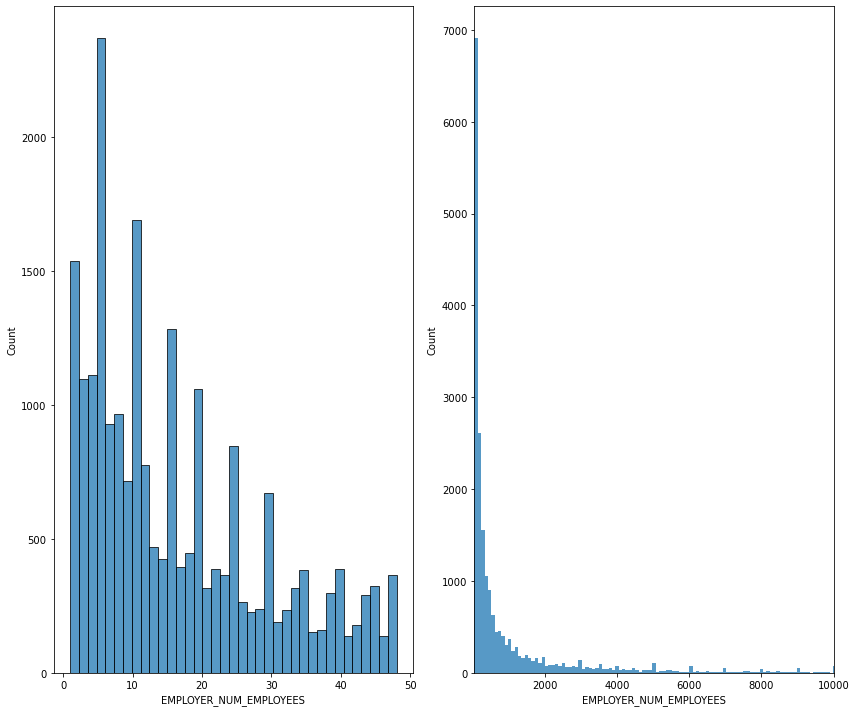

In [170]:
# PLOT THE DIST OF EMPLOYEE COUNT
btmemp = avgempnum[avgempnum<=avgempnum.median()]
topemp = avgempnum[avgempnum>avgempnum.median()]
fig, ax = plt.subplots(1,2, figsize = (12,10))
sns.histplot(x = btmemp, ax = ax[0])
topend = sns.histplot(x = topemp, ax = ax[1])
topend.set_xlim([50, 10000])
plt.tight_layout()

In [171]:
# CORRELATION ANALYSIS: NUMBER OF EMPLOYEEs WITH CASE STATUS: CASE BY CASE
st.linregress(x = df.dropna()["EMPLOYER_NUM_EMPLOYEES"], y = df.dropna()["CASE_STATUS"])
# DOES NOT SHOW MUCH, AGGREGATE MAY SHOW A DIFFERENT STORY

LinregressResult(slope=1.3243164191356925e-10, intercept=0.9418044734412306, rvalue=0.0018053124379263361, pvalue=0.20734779664839026, stderr=1.0502999191184296e-10, intercept_stderr=0.0003352246138679802)

Text(0.5, 1.0, 'Success Rates by Company Size, Over Time')

<Figure size 1200x1000 with 0 Axes>

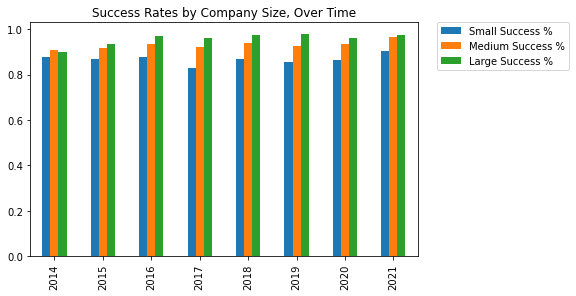

In [266]:
# CORRELATION ANALYSIS: AGGREGATE BY SIZE BRACKETS AND YEARLY
# PLOTTING SUCCESS RATES OVER TIME BY SIZE OF COMPANY

small = df[df["EMPLOYER_NUM_EMPLOYEES"]<1000]
medium = df[(df["EMPLOYER_NUM_EMPLOYEES"]>=1000)&(df["EMPLOYER_NUM_EMPLOYEES"]<10000)]
large = df[df["EMPLOYER_NUM_EMPLOYEES"]>10000]


smalldf = pd.DataFrame()
meddf = pd.DataFrame()
largedf = pd.DataFrame()
regressdf = pd.DataFrame()

for x in range(len(yr)):
    j = pd.DataFrame([len(small[(small["YEAR"]==yr[x])&small["CASE_STATUS"]==1])/len(small[small["YEAR"]==yr[x]])])
    med = pd.DataFrame([len(medium[(medium["YEAR"]==yr[x])&medium["CASE_STATUS"]==1])/len(medium[medium["YEAR"]==yr[x]])])
    lar = pd.DataFrame([len(large[(large["YEAR"]==yr[x])&large["CASE_STATUS"]==1])/len(large[large["YEAR"]==yr[x]])])
    smalldf = pd.concat([smalldf,j])
    meddf = pd.concat([meddf,med])
    largedf = pd.concat([largedf,lar])
    regressdf = pd.concat([smalldf,meddf,largedf], axis = 1)
    

regressdf.index = yr
regressdf.columns = ["Small Success %", "Medium Success %", "Large Success %"]
plt.figure(figsize = (12,10), dpi = 100)
regressdf.plot(kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Success Rates by Company Size, Over Time")

In [267]:
# PREPARING DATA FOR LIN REGRESS AND GETTING P VALUE
smallapps = []
mediumapps = []
largeapps = []
smallsd = []
mediumsd = []
largesd = []

for x in range(len(yr)):
    s = (small["YEAR"]==yr[x]).sum()
    ssd = st.tstd(small[small["YEAR"]==yr[x]]["CASE_STATUS"])
    m = (medium["YEAR"]==yr[x]).sum()
    msd = st.tstd(medium[medium["YEAR"]==yr[x]]["CASE_STATUS"])
    l = (large["YEAR"]==yr[x]).sum()
    lsd = st.tstd(large[large["YEAR"]==yr[x]]["CASE_STATUS"])
    smallapps.append(s)
    mediumapps.append(m)
    largeapps.append(l)
    smallsd.append(ssd)
    mediumsd.append(msd)
    largesd.append(lsd)
regressdf = regressdf.reset_index()
regressdf["Small Apps"] = pd.DataFrame(smallapps)
regressdf["Medium Apps"] = pd.DataFrame(mediumapps)
regressdf["Large Apps"] = pd.DataFrame(largeapps)
regressdf["Small SD"] = pd.DataFrame(smallsd)
regressdf["Medium SD"] = pd.DataFrame(mediumsd)
regressdf["Large SD"] = pd.DataFrame(largesd)
regressdf = regressdf.set_index("index")

Text(0.5, 1.0, 'Application Rates by Company Size, Over Time')

<Figure size 1200x1000 with 0 Axes>

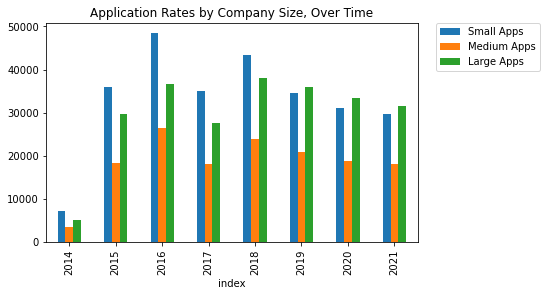

In [347]:
# PLOTTING APPLICATION RATES OVER TIME BY SIZE OF COMPANY
plt.figure(figsize = (12,10), dpi = 100)
regressdf.reset_index().plot(x = "index", y = ["Small Apps","Medium Apps","Large Apps"], kind = "bar")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Application Rates by Company Size, Over Time")

In [298]:
# P VALUE PER YEAR
small_med = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Small Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Medium Success %"]
    sample1_size = regressdf.loc[yr[x]]["Small Apps"]
    sample2_size = regressdf.loc[yr[x]]["Medium Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    small_med.append(pval)

pvaldf = pd.DataFrame(small_med)

small_large = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Small Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Large Success %"]
    sample1_size = regressdf.loc[yr[x]]["Small Apps"]
    sample2_size = regressdf.loc[yr[x]]["Large Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    small_large.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(small_large)], axis = 1)

med_large = []
for x in range(len(yr)):
    sample1_phat = regressdf.loc[yr[x]]["Medium Success %"]
    sample2_phat = regressdf.loc[yr[x]]["Large Success %"]
    sample1_size = regressdf.loc[yr[x]]["Medium Apps"]
    sample2_size = regressdf.loc[yr[x]]["Large Apps"]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    med_large.append(pval)
pvaldf = pd.concat([pvaldf,pd.DataFrame(med_large)], axis = 1)
pvaldf.columns = ["Small_Med","Small_Large","Med_Large"]
pvaldf.index = yr
pvaldf = pvaldf.head(8).style.format("{:,.4f}")
pvaldf

,Small_Med,Small_Large,Med_Large
2014,0.0000,0.0001,0.1478
2015,0.0000,0.0000,0.0000
2016,0.0000,0.0000,0.0000
2017,0.0000,0.0000,0.0000
2018,0.0000,0.0000,0.0000
2019,0.0000,0.0000,0.0000
2020,0.0000,0.0000,0.0000
2021,0.0000,0.0000,0.0000


In [337]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: SMALL COMPANY
print("Small Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Small Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Small Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Small Success %"], x = yr).rvalue,4),"\nWeak growth, .19% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: SMALL COMPANY
print("\nSmall Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Small Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Small Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Small Apps"], x = yr).rvalue,4),"\nWeak growth, 1203 applications a year, and not a statistically significant slope.")

Small Company Success Rate Over Time Slope: 0.00198 , P Val: 0.5848 , R Val: 0.2294 
Weak growth, .19% growth in success rate a year, and not a statistically significant slope.

Small Company Application Rate Over Time Slope: 1203.702 , P Val: 0.5637 , R Val: 0.242 
Weak growth, 1203 applications a year, and not a statistically significant slope.


In [332]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: MEDIUM COMPANY
print("Medium Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Medium Success %"], x = yr).rvalue,4),"\nStrong growth, .57% growth in success rate a year, with a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: MEDIUM COMPANY
print("\nMedium Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Medium Apps"], x = yr).rvalue,4),"\nDoes not appear to be growing strongly, 1122 applications a year, and not a statistically significant slope.")

Medium Company Success Rate Over Time Slope: 0.0057 , P Val: 0.0201 , R Val: 0.7884 
Strong growth, .57% growth in success rate a year, with a statistically significant slope.

Medium Company Application Rate Over Time Slope: 1122.333 , P Val: 0.3186 , R Val: 0.4058 
Does not appear to be growing strongly, 1122 applications a year, and not a statistically significant slope.


In [334]:
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND SUCCESS RATE OVER TIME: LARGE COMPANY
print("Large Company Success Rate Over Time Slope:",round(st.linregress(y = regressdf["Large Success %"], x = yr).slope,6),", P Val:",round(st.linregress(y = regressdf["Large Success %"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Large Success %"], x = yr).rvalue,4),"\nStrong growth, .83% growth in success rate a year, and not a statistically significant slope.")
# LINEAR REGRESSION BETWEEN COMPANY SIZE AND APPLICATIONS OVER TIME: LARGE COMPANY
print("\nLarge Company Application Rate Over Time Slope:",round(st.linregress(y = regressdf["Large Apps"], x = yr).slope,3),", P Val:",round(st.linregress(y = regressdf["Large Apps"], x = yr).pvalue,4),", R Val:",round(st.linregress(y = regressdf["Large Apps"], x = yr).rvalue,4),"\nModerate growth, 2523 applications a year, and not a statistically significant slope.")

Large Company Success Rate Over Time Slope: 0.008373 , P Val: 0.0312 , R Val: 0.7526 
Strong growth, .83% growth in success rate a year, and not a statistically significant slope.

Large Company Application Rate Over Time Slope: 2523.298 , P Val: 0.1291 , R Val: 0.5833 
Moderate growth, 2523 applications a year, and not a statistically significant slope.


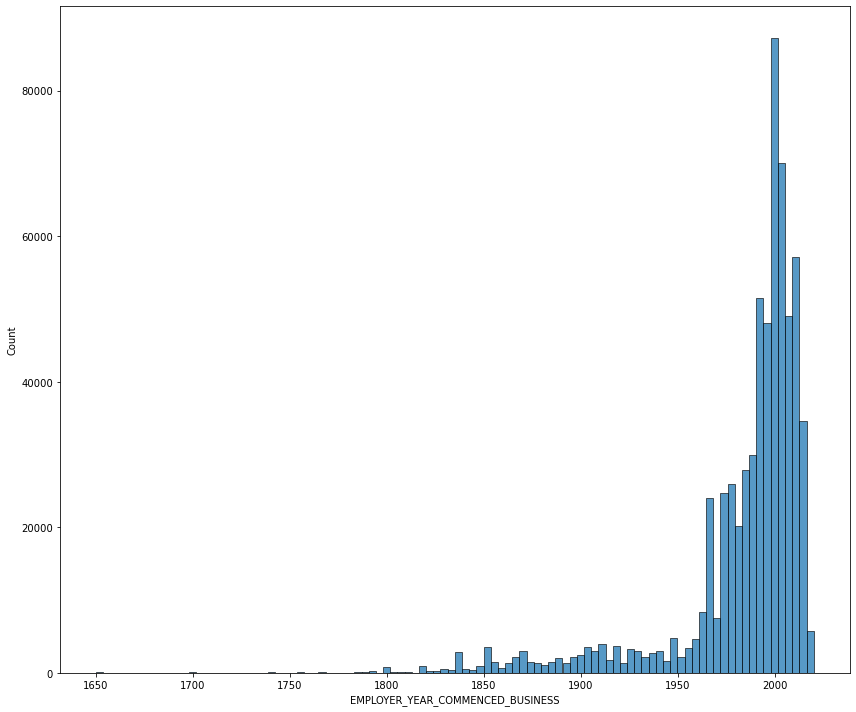

In [357]:
# DISTRIBUTION OF YEAR COMMENCED
# PLOT THE DIST OF YEAR COMMENCED
plt.figure(figsize = (12,10))
empcount = sns.histplot(x = df["EMPLOYER_YEAR_COMMENCED_BUSINESS"], bins = 100)
plt.tight_layout()

In [ ]:
#### APPLICATION / JOB RELATED #####

In [ ]:
#### WAGE ANALYSIS ####

In [ ]:
yr = df["YEAR"].unique().tolist()
yr = yr.sort()

In [ ]:
# CORREL AND LIN REG BETWEEN Wage Offered and the Year (case by case)
st.linregress(y = df.reset_index().dropna()["WO_A"], x = yr)

In [ ]:
# CORREL AND LIN REG BETWEEN Wage offered (btm 25%) and Year (in aggregate)
st.linregress(y = df.groupby("YEAR")["WO_A"].quantile(.25), x = yr)

In [ ]:
# CORREL AND LIN REG BETWEEN Wage offered (median) and Year (in aggregate)
st.linregress(y = df.groupby("YEAR")["WO_A"].quantile(.5), x = yr)

In [ ]:
# CORREL AND LIN REG BETWEEN Wage offered (top 75%) and Year (in aggregate)
st.linregress(y = df.groupby("YEAR")["WO_A"].quantile(.75), x = yr)

In [ ]:
# CORREL AND LIN REG BETWEEN WAGE OFFERED - PW WAGE and Acceptance (case by case) 
# FIRST TURN INTO A DUMMY AND THEN COMPARE WITH CASE STATUS AND COMPARE IT WITH IF WAGE OFFER NOT BIGGER: ANY DIFFERENCE?
st.linregress(x = np.where(df["OW-PW"]> 0, 1, 0),y = df["CASE_STATUS"])
st.linregress(x = np.where(df["OW-PW"]< 0, 1, 0),y = df["CASE_STATUS"])

In [ ]:
#PLOT OF AVERAGE WAGE - PW
fig,axes = plt.subplots(ncols = 2, figsize = (12,10))
df.groupby("YEAR")["OW-PW"].mean().plot(ax = axes[0],kind = "bar")
df.groupby("YEAR")["OW-PW"].quantile(.5).plot(ax = axes[1],kind = "bar")

In [ ]:
### CITY, STATE, AND REGION TO WORK IN ###

In [ ]:
# ACCEPT % BASED ON STATE HQ IN

empy = df.groupby("EMPLOYER_STATE")["CASE_STATUS"].value_counts()
empyer = pd.DataFrame(empy.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
empyer.columns = ["Percent"]
f1 = empyer.reset_index()["EMPLOYER_STATE"].tolist()
t1 = empyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
empyer.index = pd.MultiIndex.from_tuples(idx1)
empyer = empyer.reset_index()
empyer = empyer[empyer["level_1"]=="Accept"]
empyer = empyer.drop("level_1",axis = 1)

empycount = pd.DataFrame(df.groupby("EMPLOYER_STATE")["CASE_STATUS"].value_counts())
empycount.columns = ["Count"]
empycount = empycount.reset_index()
empycount = empycount[empycount["CASE_STATUS"]==1]
empycount = empycount["Count"]

empyer = pd.concat([empyer, empycount], axis = 1)
empyer.columns = ["State","Percent","Count"]
empyer["Count"] = empyer["State"].astype(str)+": "+empyer["Count"].astype(str)+" Successful Applications"
empyer

In [ ]:
# Choropleth Map of Employer State Accept %
data = dict(type = "choropleth",
           locations = empyer["State"],
           locationmode = "USA-states",
           z = empyer["Percent"].astype(float),
           text = empyer["Count"],
           colorbar={"title":"Percent Accepted"},
           colorscale = "delta",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Percent Accepted in Employer Headquartered States",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# ACCEPT % BASED ON STATE WORKED IN

joby = df.groupby("JOB_INFO_WORK_STATE")["CASE_STATUS"].value_counts()
jobyer = pd.DataFrame(joby.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)))
jobyer.columns = ["Percent"]
f1 = jobyer.reset_index()["JOB_INFO_WORK_STATE"].tolist()
t1 = jobyer.reset_index()["CASE_STATUS"].replace(1,"Accept").replace(0,"Reject").tolist()
idx1 = []
idx1.extend([tuple(a) for a in zip (f1,t1)])
jobyer.index = pd.MultiIndex.from_tuples(idx1)
jobyer = jobyer.reset_index()
jobyer = jobyer[jobyer["level_1"]=="Accept"]
jobyer = jobyer.drop("level_1",axis = 1)

jobycount = pd.DataFrame(df.groupby("JOB_INFO_WORK_STATE")["CASE_STATUS"].value_counts())
jobycount.columns = ["Count"]
jobycount = jobycount.reset_index()
jobycount = jobycount[jobycount["CASE_STATUS"]==1]
jobycount = jobycount["Count"]

jobyer = pd.concat([jobyer, jobycount], axis = 1)
jobyer.columns = ["State","Percent","Count"]
jobyer["Count"] = jobyer["State"].astype(str)+": "+jobyer["Count"].astype(str)+" Successful Applications"
jobyer

In [ ]:
# Choropleth Map of JOB State Accept %
data = dict(type = "choropleth",
           locations = jobyer["State"],
           locationmode = "USA-states",
           z = jobyer["Percent"].astype(float),
           text = jobyer["Count"],
           colorbar={"title":"Percent Accepted"},
           colorscale = "delta",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Percent Accepted in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# top 15 CITY TO WORK IN (APPLICATION)
def grab (year):
    return df[df["YEAR"]==year]["JOB_INFO_WORK_CITY"].value_counts()[:15]
top15jcityapp = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (application) Job city
kingconjc = top15jcityapp.isnull().replace(False,0).replace(True,1)
kingconjc["Yrs not in top15"] = kingconjc[2007]+kingconjc[2008]+kingconjc[2009]+kingconjc[2010]+kingconjc[2011]+kingconjc[2012]+kingconjc[2013]+kingconjc[2014]+kingconjc[2015]+kingconjc[2016]+kingconjc[2017]+kingconjc[2018]+kingconjc[2019]+kingconjc[2020]+kingconjc[2021]
kingconjc["Yrs not in top15"].sort_values()

In [ ]:
# Top 15 City TO WORK IN (SUCCESS)
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["JOB_INFO_WORK_CITY"].value_counts()[:15]
top15jcitysuc = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (success) Job city
kingconjc = top15jcitysuc.isnull().replace(False,0).replace(True,1)
kingconjc["Yrs not in top15"] = kingconjc[2007]+kingconjc[2008]+kingconjc[2009]+kingconjc[2010]+kingconjc[2011]+kingconjc[2012]+kingconjc[2013]+kingconjc[2014]+kingconjc[2015]+kingconjc[2016]+kingconjc[2017]+kingconjc[2018]+kingconjc[2019]+kingconjc[2020]+kingconjc[2021]
kingconjc["Yrs not in top15"].sort_values()

In [ ]:
##### DEEPER DIVE INTO TOP CITY ####

In [ ]:
# Working in New York City
# TOP JOB CODES in NEW YORK CITY
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["PW_SOC_CODE"].value_counts()[:15]).reset_index()
appcol.columns = ["ACode","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["PW_SOC_CODE"].value_counts()[:15]).reset_index()
succol.columns = ["SCode","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in New York City
# EMPLOYER NAMES
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
appcol.columns = ["AName","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
succol.columns = ["SName","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in New York City
# Wage Offered
print("25th Percentile Application:",round(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("25th Percentile Success:",round(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("Mean Application:",round(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Mean Success:",round(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Median Application:",round(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["WAGE_OFFER_FROM_9089"].median(),2))
print("Median Sucess:",round(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].median(),2))
print("75th Percentile Application:",round(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["WAGE_OFFER_FROM_9089"].quantile(.75),2))
print("75th Percentile Success:",round(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.75),2))

In [ ]:
# Working in New York City
# Class of Admission
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
appcol.columns = ["AClass","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
succol.columns = ["SClass","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in New York City
# Top Years
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_CITY"]=="NEW YORK"]["YEAR"].value_counts()[:15]).reset_index()
appcol.columns = ["AYear","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_CITY"]=="NEW YORK")&(df["CASE_STATUS"]==1)]["YEAR"].value_counts()[:15]).reset_index()
succol.columns = ["SYear","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in New York City
# CORREL AND LIN REG BETWEEN YEARS AND NEW YORK CITY

In [ ]:
# Top 15 State worked in (application)
def grab (year):
    return df[df["YEAR"]==year]["JOB_INFO_WORK_STATE"].value_counts()[:15]
top15jstateapp = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (application) Job state
kingconjc = top15jstateapp.isnull().replace(False,0).replace(True,1)
kingconjc["Yrs not in top15"] = kingconjc[2007]+kingconjc[2008]+kingconjc[2009]+kingconjc[2010]+kingconjc[2011]+kingconjc[2012]+kingconjc[2013]+kingconjc[2014]+kingconjc[2015]+kingconjc[2016]+kingconjc[2017]+kingconjc[2018]+kingconjc[2019]+kingconjc[2020]+kingconjc[2021]
kingconjc["Yrs not in top15"].sort_values()

In [ ]:
# Top 15 State worked in (success)
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["JOB_INFO_WORK_STATE"].value_counts()[:15]
top15jstatesuc = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (success) Job state
kingconjc = top15jstatesuc.isnull().replace(False,0).replace(True,1)
kingconjc["Yrs not in top15"] = kingconjc[2007]+kingconjc[2008]+kingconjc[2009]+kingconjc[2010]+kingconjc[2011]+kingconjc[2012]+kingconjc[2013]+kingconjc[2014]+kingconjc[2015]+kingconjc[2016]+kingconjc[2017]+kingconjc[2018]+kingconjc[2019]+kingconjc[2020]+kingconjc[2021]
kingconjc["Yrs not in top15"].sort_values()

In [ ]:
##### DEEPER DIVE INTO TOP STATE ####

In [ ]:
# Working in CA State
# TOP JOB CODES in CA 
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_STATE"]=="CA"]["PW_SOC_CODE"].value_counts()[:15]).reset_index()
appcol.columns = ["ACode","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["PW_SOC_CODE"].value_counts()[:15]).reset_index()
succol.columns = ["SCode","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in CA State
# EMPLOYER NAMES
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_STATE"]=="CA"]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
appcol.columns = ["AName","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
succol.columns = ["SName","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in CA State
# Wage Offered
print("25th Percentile Application:",round(df[df["JOB_INFO_WORK_STATE"]=="CA"]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("25th Percentile Success:",round(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("Mean Application:",round(df[df["JOB_INFO_WORK_STATE"]=="CA"]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Mean Success:",round(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Median Application:",round(df[df["JOB_INFO_WORK_STATE"]=="CA"]["WAGE_OFFER_FROM_9089"].median(),2))
print("Median Sucess:",round(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].median(),2))
print("75th Percentile Application:",round(df[df["JOB_INFO_WORK_STATE"]=="CA"]["WAGE_OFFER_FROM_9089"].quantile(.75),2))
print("75th Percentile Success:",round(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.75),2))

In [ ]:
# Working in CA State
# Class of Admission
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_STATE"]=="CA"]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
appcol.columns = ["AClass","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
succol.columns = ["SClass","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in CA State
# Top Years
appcol = pd.DataFrame(df[df["JOB_INFO_WORK_STATE"]=="CA"]["YEAR"].value_counts()[:15]).reset_index()
appcol.columns = ["AYear","ACount"]
succol = pd.DataFrame(df[(df["JOB_INFO_WORK_STATE"]=="CA")&(df["CASE_STATUS"]==1)]["YEAR"].value_counts()[:15]).reset_index()
succol.columns = ["SYear","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# Working in CA State
# CORREL AND LIN REG BETWEEN YEARS AND CA 

In [ ]:
#### JOB CODE ANALYSIS #####

In [ ]:
# TOP 15 JOB CODES
allcode = pd.DataFrame(df["PW_SOC_CODE"].value_counts()[:15]).reset_index()
allcode.columns = ["ACODE","COUNT ACODE"]
succode = pd.DataFrame(df[df["CASE_STATUS"]==1]["PW_SOC_CODE"].value_counts()[:15]).reset_index()
succode.columns = ["SCODE","COUNT SCODE"]
pd.concat([allcode,succode], axis = 1)

In [ ]:
# TOP 15 Apps codes
def grab (year):
    return df[df["YEAR"]==year]["PW_SOC_CODE"].value_counts()[:15]
top15code = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (application)
kingconjc = top15code.isnull().replace(False,0).replace(True,1)
kingconjc["Yrs not in top15"] = kingconjc[2007]+kingconjc[2008]+kingconjc[2009]+kingconjc[2010]+kingconjc[2011]+kingconjc[2012]+kingconjc[2013]+kingconjc[2014]+kingconjc[2015]+kingconjc[2016]+kingconjc[2017]+kingconjc[2018]+kingconjc[2019]+kingconjc[2020]+kingconjc[2021]
kingconjc["Yrs not in top15"].sort_values()

In [ ]:
# TOP 15 Success Codes
def grab (year):
    return df[(df["YEAR"]==year)&(df["CASE_STATUS"]==1)]["PW_SOC_CODE"].value_counts()[:15]
top15acode = pd.DataFrame([grab(2007),grab(2008),grab(2009),grab(2010),
             grab(2011),grab(2012),grab(2013),grab(2014),grab(2015),
             grab(2016),grab(2017),grab(2018),grab(2019),grab(2020),
             grab(2021)], index = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
                                  2018,2019,2020,2021]).transpose()
# King of Consistency: Count the N in top 15 (success)
kingconsjc = top15acode.isnull().replace(False,0).replace(True,1)
kingconsjc["Yrs not in top15"] = kingconsjc[2007]+kingconsjc[2008]+kingconsjc[2009]+kingconsjc[2010]+kingconsjc[2011]+kingconsjc[2012]+kingconsjc[2013]+kingconsjc[2014]+kingconsjc[2015]+kingconsjc[2016]+kingconsjc[2017]+kingconsjc[2018]+kingconsjc[2019]+kingconsjc[2020]+kingconsjc[2021]
kingconsjc["Yrs not in top15"].sort_values()

In [ ]:
##### DEEPER DIVE INTO TOP 3 JOB CODE ####

In [ ]:
# 11-3021
# Computer and Information Systems Managers
# 17-2072
# Electronics Engineers, Except Computer
# 17-2141
# Mechanical Engineers

In [ ]:
# 11-3021, Computer and Information Systems Managers

# TOP CITIES WORKED IN
appcol = pd.DataFrame(df[df["PW_SOC_CODE"]=="11-3021"]["JOB_INFO_WORK_CITY"].value_counts()[:15]).reset_index()
appcol.columns = ["ACity","ACount"]
succol = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["JOB_INFO_WORK_CITY"].value_counts()[:15]).reset_index()
succol.columns = ["SCity","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# TOP STATES WORKED IN 
appcol = pd.DataFrame(df[df["PW_SOC_CODE"]=="11-3021"]["JOB_INFO_WORK_STATE"].value_counts()[:15]).reset_index()
appcol.columns = ["AState","ACount"]
succol = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["JOB_INFO_WORK_STATE"].value_counts()[:15]).reset_index()
succol.columns = ["SState","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
jobcho = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["JOB_INFO_WORK_STATE"].value_counts()).reset_index()
jobcho.columns = ["SState","SCount"]
jobcho["text"] = jobcho["SState"].astype(str)+": "+jobcho["SCount"].astype(str)+" Successful Applications"
# Choropleth Map of EMPLOYER STATE
data = dict(type = "choropleth",
           locations = jobcho["SState"],
           locationmode = "USA-states",
           z = jobcho["SCount"].astype(float),
           text = jobcho["text"],
           colorbar={"title":"Applications"},
           colorscale = "oranges",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Successful 11-3021 Applications in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# 11-3021, Computer and Information Systems Managers
# EMPLOYER NAME
appcol = pd.DataFrame(df[df["PW_SOC_CODE"]=="11-3021"]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
appcol.columns = ["AName","ACount"]
succol = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["EMPLOYER_NAME"].value_counts()[:15]).reset_index()
succol.columns = ["SName","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# 11-3021, Computer and Information Systems Managers
# Wage Offered
print("25th Percentile Application:",round(df[df["PW_SOC_CODE"]=="11-3021"]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("25th Percentile Success:",round(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.25),2))
print("Mean Application:",round(df[df["PW_SOC_CODE"]=="11-3021"]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Mean Success:",round(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].mean(),2))
print("Median Application:",round(df[df["PW_SOC_CODE"]=="11-3021"]["WAGE_OFFER_FROM_9089"].median(),2))
print("Median Sucess:",round(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].median(),2))
print("75th Percentile Application:",round(df[df["PW_SOC_CODE"]=="11-3021"]["WAGE_OFFER_FROM_9089"].quantile(.75),2))
print("75th Percentile Success:",round(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["WAGE_OFFER_FROM_9089"].quantile(.75),2))

In [ ]:
# 11-3021, Computer and Information Systems Managers
# Class of Admission
appcol = pd.DataFrame(df[df["PW_SOC_CODE"]=="11-3021"]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
appcol.columns = ["AClass","ACount"]
succol = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["CLASS_OF_ADMISSION"].value_counts()[:15]).reset_index()
succol.columns = ["SClass","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# 11-3021, Computer and Information Systems Managers
# Top Years
appcol = pd.DataFrame(df[df["PW_SOC_CODE"]=="11-3021"]["YEAR"].value_counts()[:15]).reset_index()
appcol.columns = ["AYear","ACount"]
succol = pd.DataFrame(df[(df["PW_SOC_CODE"]=="11-3021")&(df["CASE_STATUS"]==1)]["YEAR"].value_counts()[:15]).reset_index()
succol.columns = ["SYear","SCount"]
pd.concat([appcol,succol], axis = 1)

In [ ]:
# 11-3021, Computer and Information Systems Managers
# CORREL AND LIN REG BETWEEN YEARS AND APPLICATIONS


In [ ]:
### JOB LEVEL ANALYSIS ###

In [ ]:
# DISTRIBUTION OF JOB LEVEL OVER TIME
plt.figure(figsize=(12,10))
sns.countplot(x = "YEAR", hue = "PW_LEVEL_9089",data=df,hue_order=["LEVEL I","LEVEL II","LEVEL III","LEVEL IV"])

In [ ]:
# SUCCESS % OF JOB LEVEL IN AGGREGATE
lo = df[df["PW_LEVEL_9089"] == "LEVEL I"]["CASE_STATUS"].sum()/len(df[df["PW_LEVEL_9089"] == "LEVEL I"])
lt = df[df["PW_LEVEL_9089"] == "LEVEL II"]["CASE_STATUS"].sum()/len(df[df["PW_LEVEL_9089"] == "LEVEL II"])
lth = df[df["PW_LEVEL_9089"] == "LEVEL III"]["CASE_STATUS"].sum()/len(df[df["PW_LEVEL_9089"] == "LEVEL III"])
lf = df[df["PW_LEVEL_9089"] == "LEVEL IV"]["CASE_STATUS"].sum()/len(df[df["PW_LEVEL_9089"] == "LEVEL IV"])
#SIMPLE AVG
salw =(lo+lt+lth+lf)/4 
#WEIGHTED AVG
walw = (len(df[df["PW_LEVEL_9089"] == "LEVEL I"])*lo+
len(df[df["PW_LEVEL_9089"] == "LEVEL II"])*lt+
len(df[df["PW_LEVEL_9089"] == "LEVEL III"])*lth+
len(df[df["PW_LEVEL_9089"] == "LEVEL IV"])*lf)/len(df[df["PW_LEVEL_9089"].notna()])
#MERGING ALL
la = pd.DataFrame([lo,lt,lth,lf,salw,walw]).transpose()
la.columns=["LEVEL I","LEVEL II","LEVEL III","LEVEL IV","AVG","WAVG"]
la

In [ ]:
# GET A GROUPBY ON THE YEAR AND SEE EACH LEVELS SUCCESS AND APPLICATION COUNT
#PLOT THAT
# GET CORREL AND LIN REG OF THE SUCCESS AND APP COUNT OVER TIME FOR EACH LEVEL 

In [ ]:
# PW LEVEL DIST PER STATE WORKED IN
joblevel = pd.DataFrame(df.groupby("JOB_INFO_WORK_STATE")["PW_LEVEL_9089"].value_counts())
joblevel.columns = ["Count"]
joblevel = joblevel.reset_index()

In [ ]:
# LEVEL 1 DISTRIBUTION BY STATES WORKED IN
jobcho = joblevel[joblevel["PW_LEVEL_9089"]=="LEVEL I"]
jobcho.columns = ["State","Level","Count"]
jobcho["text"] = jobcho["State"].astype(str)+": "+jobcho["Count"].astype(str)+" Applications"
# Choropleth Map of EMPLOYER STATE
data = dict(type = "choropleth",
           locations = jobcho["State"],
           locationmode = "USA-states",
           z = jobcho["Count"].astype(float),
           text = jobcho["text"],
           colorbar={"title":"Applications"},
           colorscale = "oranges",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Level I Applications in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# LEVEL 2 DISTRIBUTION BY STATES WORKED IN
jobcho = joblevel[joblevel["PW_LEVEL_9089"]=="LEVEL II"]
jobcho.columns = ["State","Level","Count"]
jobcho["text"] = jobcho["State"].astype(str)+": "+jobcho["Count"].astype(str)+" Applications"
# Choropleth Map of EMPLOYER STATE
data = dict(type = "choropleth",
           locations = jobcho["State"],
           locationmode = "USA-states",
           z = jobcho["Count"].astype(float),
           text = jobcho["text"],
           colorbar={"title":"Applications"},
           colorscale = "oranges",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Level II Applications in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# LEVEL 3 DISTRIBUTION BY STATES WORKED IN
jobcho = joblevel[joblevel["PW_LEVEL_9089"]=="LEVEL III"]
jobcho.columns = ["State","Level","Count"]
jobcho["text"] = jobcho["State"].astype(str)+": "+jobcho["Count"].astype(str)+" Applications"
# Choropleth Map of EMPLOYER STATE
data = dict(type = "choropleth",
           locations = jobcho["State"],
           locationmode = "USA-states",
           z = jobcho["Count"].astype(float),
           text = jobcho["text"],
           colorbar={"title":"Applications"},
           colorscale = "oranges",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Level III Applications in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)

In [ ]:
# LEVEL 4 DISTRIBUTION BY STATES WORKED IN
jobcho = joblevel[joblevel["PW_LEVEL_9089"]=="LEVEL IV"]
jobcho.columns = ["State","Level","Count"]
jobcho["text"] = jobcho["State"].astype(str)+": "+jobcho["Count"].astype(str)+" Applications"
# Choropleth Map of EMPLOYER STATE
data = dict(type = "choropleth",
           locations = jobcho["State"],
           locationmode = "USA-states",
           z = jobcho["Count"].astype(float),
           text = jobcho["text"],
           colorbar={"title":"Applications"},
           colorscale = "oranges",
           marker = dict(line = dict(color = "rgb(255,255,255)")) )
layout = dict(title = "Level IV Applications in States Worked In",
              geo = dict(scope = "usa",showlakes = True, lakecolor = "rgb(255,255,255)"))
choro = go.Figure(data, layout)
iplot(choro)